In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import cmocean
import cmocean.cm as cmo
import numpy.ma as ma
import gsw 
import geopy.distance
import matplotlib.cm as cm
import math
from matplotlib.ticker import MultipleLocator, FuncFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.dates as mdates
import datetime
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import Formatter
from matplotlib.lines import Line2D
from scipy import signal


## Figure 1 

In [2]:
########Argo Roemich-Gilson Climatology 

#downloaded index from website 
path = '/Users/Lauryn/THESIS/RG_ArgoClim_Temp.nc'
ds = xr.open_dataset(path,decode_times=False)
sept19= 12*15+8 #15 years to Jan 2019 + 8 months until Sept (the start of the first glider mission in project) 
temp = ds.sel(PRESSURE = 500, method='nearest').sel(TIME=slice(sept19,246.5)) #at 500m depth 
temp['LONGITUDE'] =  temp.LONGITUDE-360
temp = temp.sel(LONGITUDE=slice(-160,-125),LATITUDE=slice(40,60))
temp_values = temp.ARGO_TEMPERATURE_ANOMALY+temp.ARGO_TEMPERATURE_MEAN #find temp values using anomaly 


path = '/Users/Lauryn/THESIS/RG_ArgoClim_Sal.nc'
ds = xr.open_dataset(path,decode_times=False)
sept19= 12*15+8 #15 years to Jan 2019 + 8 months until Sept 
sal = ds.sel(PRESSURE = 500, method='nearest').sel(TIME=slice(sept19,246.5))
sal['LONGITUDE'] =  sal.LONGITUDE-360
sal = sal.sel(LONGITUDE=slice(-160,-125),LATITUDE=slice(40,60))
sal_values = sal.ARGO_SALINITY_ANOMALY+sal.ARGO_SALINITY_MEAN


#calculate potential temperature at 500 m depth 
pot_temp = gsw.pt_from_t(sal_values,temp_values,500,0)

#open file with 15 glider missions 
glider =  xr.open_dataset('/Users/Lauryn/THESIS/CPROOF_Work/Files/good_files/all_files15.nc')

#######Copernicus SSH 
SSH = xr.open_dataset('/Users/Lauryn/THESIS/SSH20182023.nc')
SSH2024 = xr.open_dataset('/Users/Lauryn/THESIS/SSH2023_2024.nc')#different file for 2024
SSH_all = xr.concat([SSH,SSH2024],dim=('time'))
SSH_all['longitude']=SSH_all.longitude-360
SSH_all = SSH_all.sel(latitude=slice(40,60),longitude=slice(-160,-125))
SSH_all=SSH_all.sortby("time")

In [4]:
## find mean theta^* from Sept 19 2019 - Sept 1 2024 (glider time limits)
mn_sst =  pot_temp.isel(TIME=slice(0,-1)).mean('TIME') #Sept 19 2019 - Sept 1 2024
new_anom = (mn_sst-glider.pot_temp_mean.values[500])/glider.pot_temp_std[500] #theta^* at 500m depth 
land_mask = np.isnan(mn_sst)  # times has same shape as new_anom
new_anom_masked = np.ma.masked_where(land_mask, new_anom)

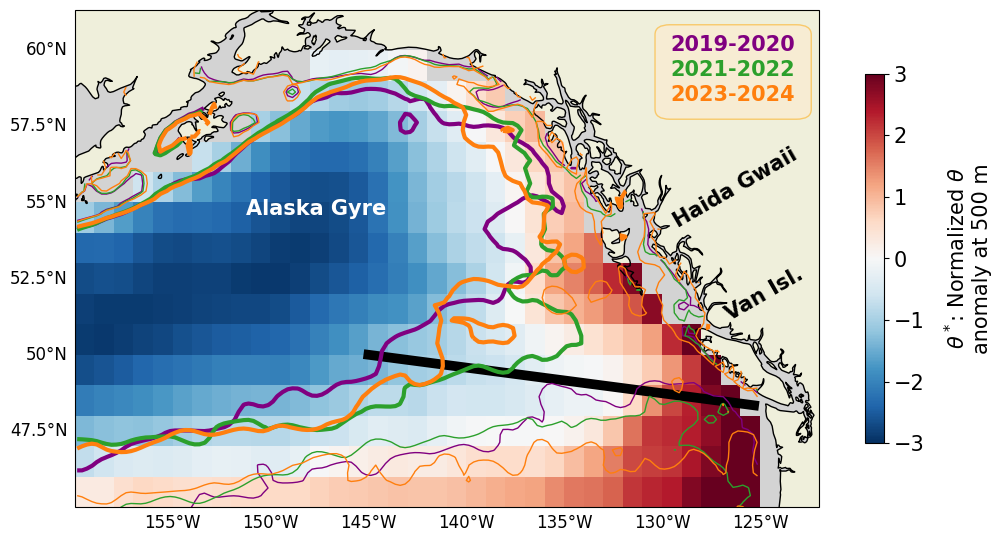

In [5]:
fig = plt.figure(figsize=(12, 8))
axs = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

########Plot map 
axs.set_facecolor('lightgray') 
im=axs.pcolormesh(new_anom.LONGITUDE,new_anom.LATITUDE,new_anom_masked, vmin=-3,vmax=3,cmap='RdBu_r',rasterized=True)
axs.plot([-125.3,-145],[48.34,50],c='k',linewidth=7)
axs.set_aspect(1/np.cos(50*np.pi/180))
axs.set_extent([-122,-160,45,60])
axs.add_feature(cfeature.LAND)
axs.add_feature(cfeature.COASTLINE)
cbar = fig.colorbar(im, shrink=0.6)  
cbar.ax.set_ylabel(r'$\theta^*$: Normalized$\ \theta$' + '\n' + r'anomaly at 500 m', 
                   fontsize=15, labelpad=14)
cbar.ax.tick_params(labelsize=15)

gl = axs.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlines = False
gl.ylines = False

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

####### Add sdtreamlines of mean gyre size 
times=[slice('2019-01-01T00:00:00.000000000','2020-12-31T00:00:00.000000000'),
       slice('2021-01-01T00:00:00.000000000','2022-12-31T00:00:00.000000000'),
       slice('2023-01-01T00:00:00.000000000','2024-12-01T00:00:00.000000000')] #three years chosen for range 

c=['purple','tab:green','tab:orange']

def streamlines(time_slice, ax,c):
        ds_SH = SSH_all.sel(time=time_slice).mean('time')
        CS=ax.contour(ds_SH.longitude,ds_SH.latitude,ds_SH.adt,colors=c, levels=[0.44],linewidths=3)
        CS=ax.contour(ds_SH.longitude,ds_SH.latitude,ds_SH.adt,colors=c, levels=[0.52],linewidths=1)

for i ,time in enumerate(times):
    streamlines(time,axs,c[i])

    
labels = ['2019-2020','2021-2022','2023-2024']
x = 0.8
y_start = 0.95
dy = 0.05 

### Add a background rectangle that covers all the text
height = dy * len(labels)
axs.add_patch(mpatches.FancyBboxPatch((x, y_start - height), 0.17, height,
                                      transform=axs.transAxes,
                                      boxstyle='round,pad=0.02',
                                      fc='blanchedalmond', ec='orange', alpha=0.5,
                                      zorder=1))

######## Add each line of text
for i, label in enumerate(labels):
    axs.text(x, y_start - dy * i, label, transform=axs.transAxes,
             fontsize=15, fontweight='bold', va='top', ha='left',
             color=c[i], zorder=2)

########Label 
axs.text(0.87, 0.49, 'Van Isl.', transform=axs.transAxes,
             fontsize=15, fontweight='bold', va='top', ha='left',
             color='k',rotation=30, zorder=2)

axs.text(0.8, 0.73, 'Haida Gwaii', transform=axs.transAxes,
             fontsize=15, fontweight='bold', va='top', ha='left',
             color='k',rotation=30, zorder=2)

axs.text(0.23, 0.62, 'Alaska Gyre', transform=axs.transAxes,
             fontsize=15, fontweight='bold', va='top', ha='left',
             color='white', zorder=2)

plt.savefig("gyre_map2.pdf", format="pdf", bbox_inches="tight", dpi=150)

## Figure 2 

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_61602/1165970536.py:20: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  mdates.date2num(datetime.datetime.utcfromtimestamp(t)) if np.isfinite(t) else np.nan
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_61602/1165970536.py:28: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  first_time = datetime.datetime.utcfromtimestamp(np.nanmin(flat_valid_times))
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_61602/1165970536.py:29: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version.

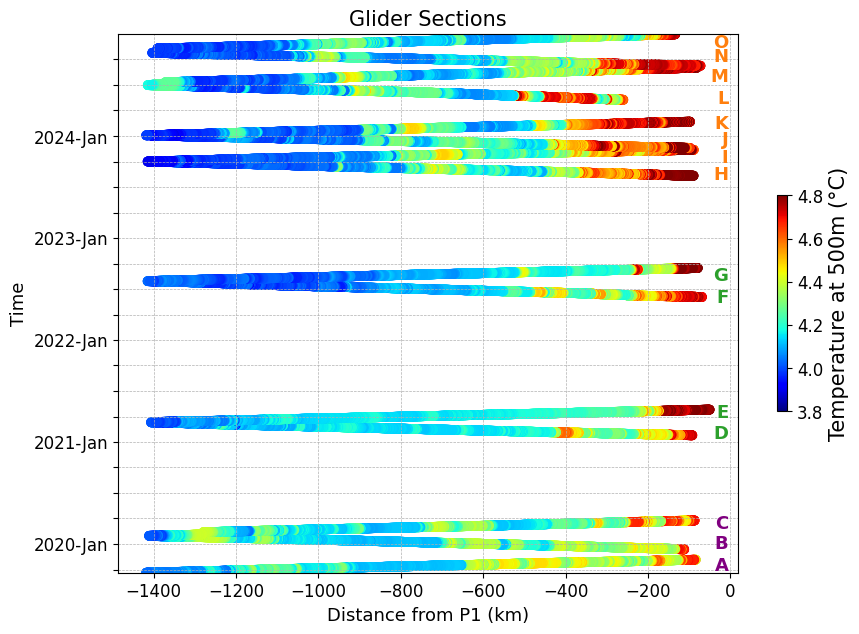

In [6]:
#open file with 15 glider missions 
all_sections_combined =  xr.open_dataset('/Users/Lauryn/THESIS/CPROOF_Work/Files/good_files/all_files15.nc')

fig, axs = plt.subplots(figsize=(10, 7))

##### Plot 
all_valid_times = []
vmin=3.8 #arbitrary range to show variance between missions 
vmax=4.8


for i in range(15):
    time_array = all_sections_combined.time.isel(file=i)[0].values   
    distance = all_sections_combined.distance.values
    temp_500 = all_sections_combined.isel(file=i,depth=500).iso_temps #take values at 500m depth     
    all_valid_times.append(time_array[np.isfinite(time_array)])

    # Convert UNIX to matplotlib date format, keeping NaNs
    time_array_dates = np.array([
        mdates.date2num(datetime.datetime.utcfromtimestamp(t)) if np.isfinite(t) else np.nan
        for t in time_array
    ])

    im=axs.scatter(distance, time_array_dates, c=temp_500, cmap='jet',vmin=vmin,vmax=vmax)

#### Set y-axis limits from valid times
flat_valid_times = np.concatenate(all_valid_times)
first_time = datetime.datetime.utcfromtimestamp(np.nanmin(flat_valid_times))
last_time = datetime.datetime.utcfromtimestamp(np.nanmax(flat_valid_times))
axs.set_ylim(mdates.date2num(first_time), mdates.date2num(last_time))
axs.grid(axis='y', linestyle='--', linewidth=0.5)
axs.grid(axis='x', linestyle='--', linewidth=0.5)

locator = mdates.MonthLocator(bymonth=[1, 4, 7, 10])

# label Jan only
class JanFormatter(Formatter):
    def __call__(self, x, pos=0):
        dt = mdates.num2date(x)
        if dt.month == 1:
            return dt.strftime('%Y-%b')  # '2022-Jan'
        else:
            return ''  # no label

formatter = JanFormatter()

# Apply to axis
axs.yaxis.set_major_locator(locator)
axs.yaxis.set_major_formatter(formatter)


axs.set_ylabel('Time',fontsize=13)
axs.set_xlabel('Distance from P1 (km)', fontsize=13)
cbar = fig.colorbar(im, shrink=0.4)
cbar.set_label('Temperature at 500m (°C)', fontsize=15)
cbar.ax.tick_params(labelsize=12)
axs.tick_params(axis='y', labelsize=12)       
axs.tick_params(axis='x', labelsize=12)       
axs.set_title('Glider Sections', fontsize=15)

############# Add labels 

times=[[mdates.date2num(datetime.datetime(2019, 10, 15)),mdates.date2num(datetime.datetime(2020, 1, 1)),
       mdates.date2num(datetime.datetime(2020, 3, 15))],
       [mdates.date2num(datetime.datetime(2021, 2, 1)), mdates.date2num(datetime.datetime(2021, 4 ,15)),
       mdates.date2num(datetime.datetime(2022, 6, 1)),  mdates.date2num(datetime.datetime(2022, 8, 20))],
       [mdates.date2num(datetime.datetime(2023, 8, 15)), mdates.date2num(datetime.datetime(2023, 10, 15)),
       mdates.date2num(datetime.datetime(2023, 12, 20)),  mdates.date2num(datetime.datetime(2024, 2, 15)),
       mdates.date2num(datetime.datetime(2024, 5, 15)), mdates.date2num(datetime.datetime(2024, 8, 1)),
       mdates.date2num(datetime.datetime(2024, 10, 12)), mdates.date2num(datetime.datetime(2024, 11, 30))]]

labels=[['A','B','C'],['D','E','F','G'],['H','I','J','K','L','M','N','O']]
c=['purple','tab:green','tab:orange']
for i in range(3):
    for j in range(len(times[i])):
        axs.text(x=distance.max() - 5,  # or a fixed value like -10
         y=times[i][j],s=labels[i][j],va='center',ha='right',fontsize=13,color=c[i],fontweight='bold')


plt.savefig("timeline_indx.pdf", format="pdf", bbox_inches="tight")


## Figure 3

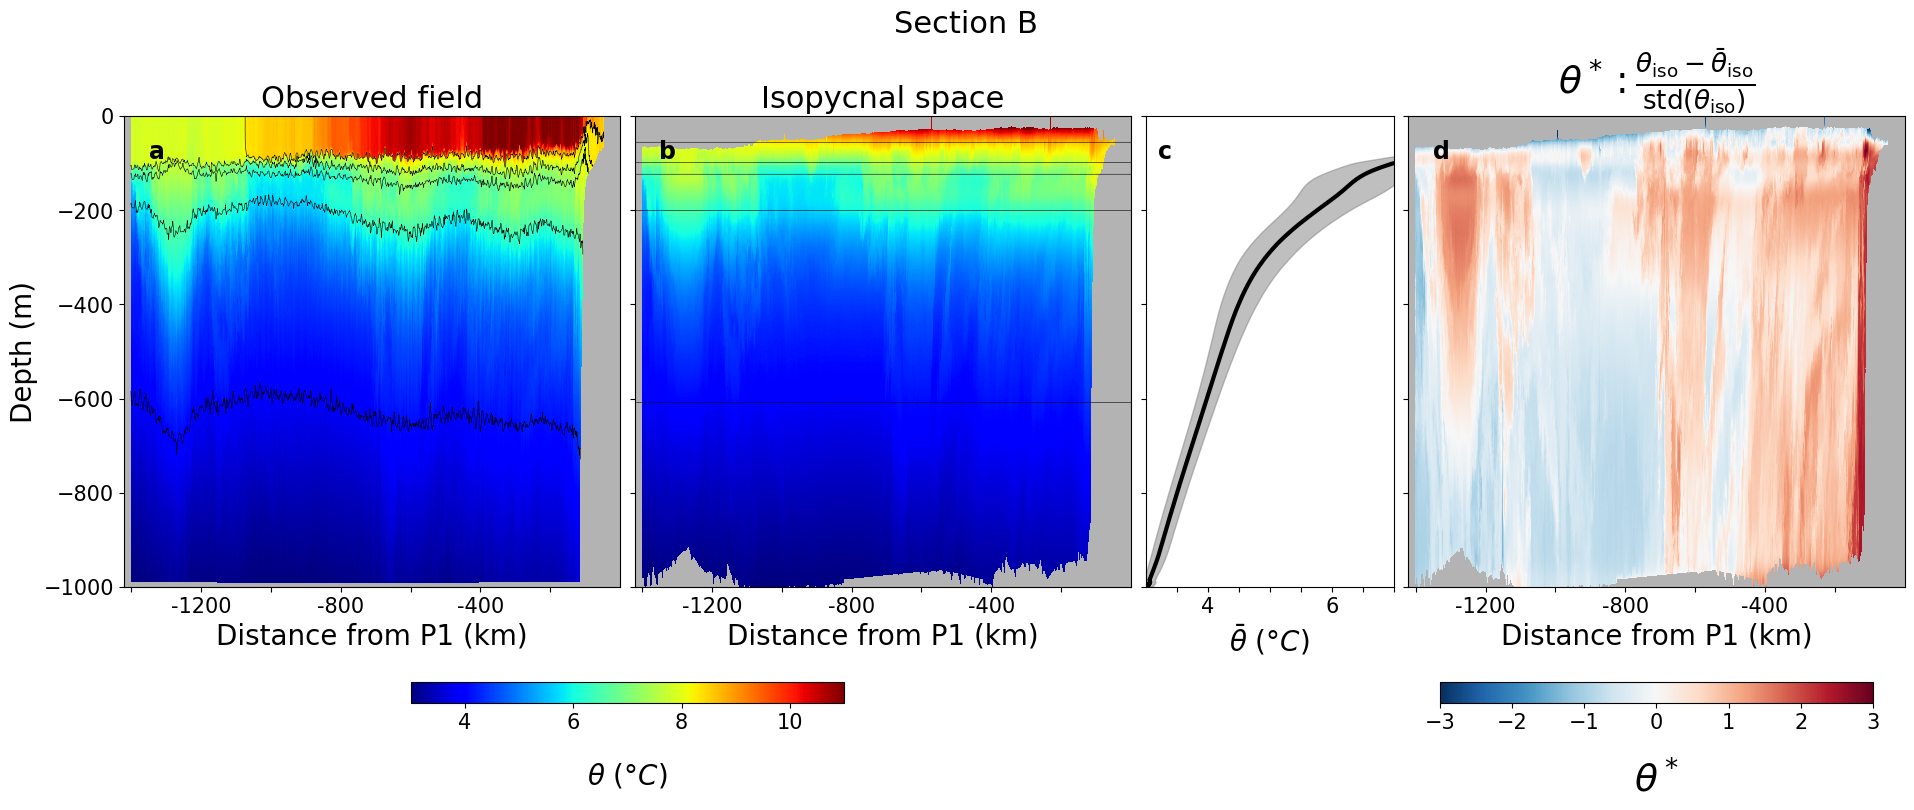

In [7]:
#open file with 15 glider missions 
all_sections_combined =  xr.open_dataset('/Users/Lauryn/THESIS/CPROOF_Work/Files/good_files/all_files15.nc')

#Select glider section B for example plot  
section=all_sections_combined.isel(file=1)


fig = plt.figure(figsize=(24, 8), layout='constrained')

# Create subplots using GridSpec
gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 0.5, 1, 1], figure=fig)  # axs[2] is 0.5x width
axs = [
    fig.add_subplot(gs[0]),  # axs[0] (Full width)
    fig.add_subplot(gs[1]),  # axs[1] (Full width)
    fig.add_subplot(gs[2]),  # axs[2] (Half width)
    fig.add_subplot(gs[3]),  # axs[3] (Full width)
]


### Plot 1
im1=axs[0].pcolormesh(section.distance, -section.depth, section.potential_temperature,cmap= 'jet',vmin=3, vmax=11, rasterized=True)
axs[0].contour(section.distance, -section.depth, section.pot_density, levels=[1025,1025.5,1026,1026.5,1027], colors='k', linewidths=0.4)
axs[0].set_title(r'Observed field', fontsize=22)
axs[0].set_xlabel( 'Distance from P1 (km)', fontsize=20)
axs[0].set_facecolor('0.7')
axs[0].set_ylim(-1000,0)
axs[0].tick_params(axis='y', labelsize=15)

### Plot 2 
axs[1].pcolormesh(section.distance, -section.depth, section.iso_temps.T,cmap= 'jet',vmin=3, vmax=11, rasterized=True)
axs[1].contour(section.distance, -section.depth, section.iso_density, levels=[1025,1025.5,1026,1026.5,1027], colors='k', linewidths=0.4)
axs[1].set_title(r'Isopycnal space', fontsize=22)
axs[1].set_facecolor('0.7')
axs[1].set_ylim(-1000,0)

#common colorbar 
cbar1 = fig.colorbar(im1, ax=[axs[0], axs[1]], location='bottom', fraction=0.046, pad=0.05)
cbar1.ax.tick_params(labelsize=15)
cbar1.ax.set_xlabel(r'$\theta\ (\degree C)$', fontsize=20,labelpad=20)

###Plot 3

axs[2].plot(section.pot_temp_mean,-section.depth, linewidth=3, c='black')
axs[2].fill_betweenx(-section.depth, section.pot_temp_mean - section.pot_temp_std, 
                  section.pot_temp_mean + section.pot_temp_std, color='gray', alpha=0.5)
axs[2].set_facecolor('white')
axs[2].set_xlabel( r'$\bar{\theta}\ (\degree C)$', fontsize=20)
axs[2].set_ylim(-1000,0)
axs[2].set_xlim(3,7)
axs[2].tick_params(labelsize=15)
axs[2].set_xticks([3.5,4,4.5,5,5.5,6,6.5,7])  # Ensure x-ticks are shown
axs[2].set_xticklabels(["", 4,'','','',6,'',''])
    
###Plot 4 
vmin=-3;vmax=3 
im2=axs[3].pcolormesh(section.distance, -section.depth, 
                      ((section.iso_temps- all_sections_combined.pot_temp_mean)/all_sections_combined.pot_temp_std).T,
                      cmap= 'RdBu_r',vmin=vmin, vmax=vmax, rasterized=True)
axs[3].set_title(r'$ \theta^* : \frac{\theta_{\text{iso}} - \bar{\theta}_{\text{iso}}}{\text{std}(\theta_{\text{iso}})}$', fontsize=27)

cbar2 = fig.colorbar(im2,ax = axs[3], location='bottom',fraction=0.046, pad=0.05)  
cbar2.ax.tick_params(labelsize=15)
cbar2.ax.set_xlabel(r'$ \theta^* $',
                    fontsize=27,labelpad=20)
axs[3].set_xlabel( 'Distance from P1 (km)', fontsize=20)
axs[3].set_facecolor('0.7')
axs[3].set_ylim(-1000,0)


### Adjusst labels 
for ax in [axs[0], axs[1], axs[3]]:
    ax.tick_params(labelsize=15)
    ax.set_xticks([-200, -400, -600, -800, -1000, -1200, -1400])  # Ensure x-ticks are shown
    ax.set_xticklabels([ '', -400,'' , -800, '', -1200,""])

for ax in [axs[1], axs[2], axs[3]]:
    ax.set_ylabel('')  # Remove y-axis label
    ax.set_yticklabels([])

axs[1].set_xlabel( 'Distance from P1 (km)', fontsize=20)
axs[0].set_ylabel('Depth (m)', fontsize=20)


labels = ['a', 'b', 'c','d']
count = 0
for ax, label in zip(axs, labels):
    c= 'black'
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
            fontsize=17, fontweight='bold', va='top', ha='left',color=c)

fig.suptitle('Section B', x=0.4, fontsize=22)

fig.savefig('steps.pdf', format="pdf", bbox_inches="tight", dpi=150)

## Figure 4 

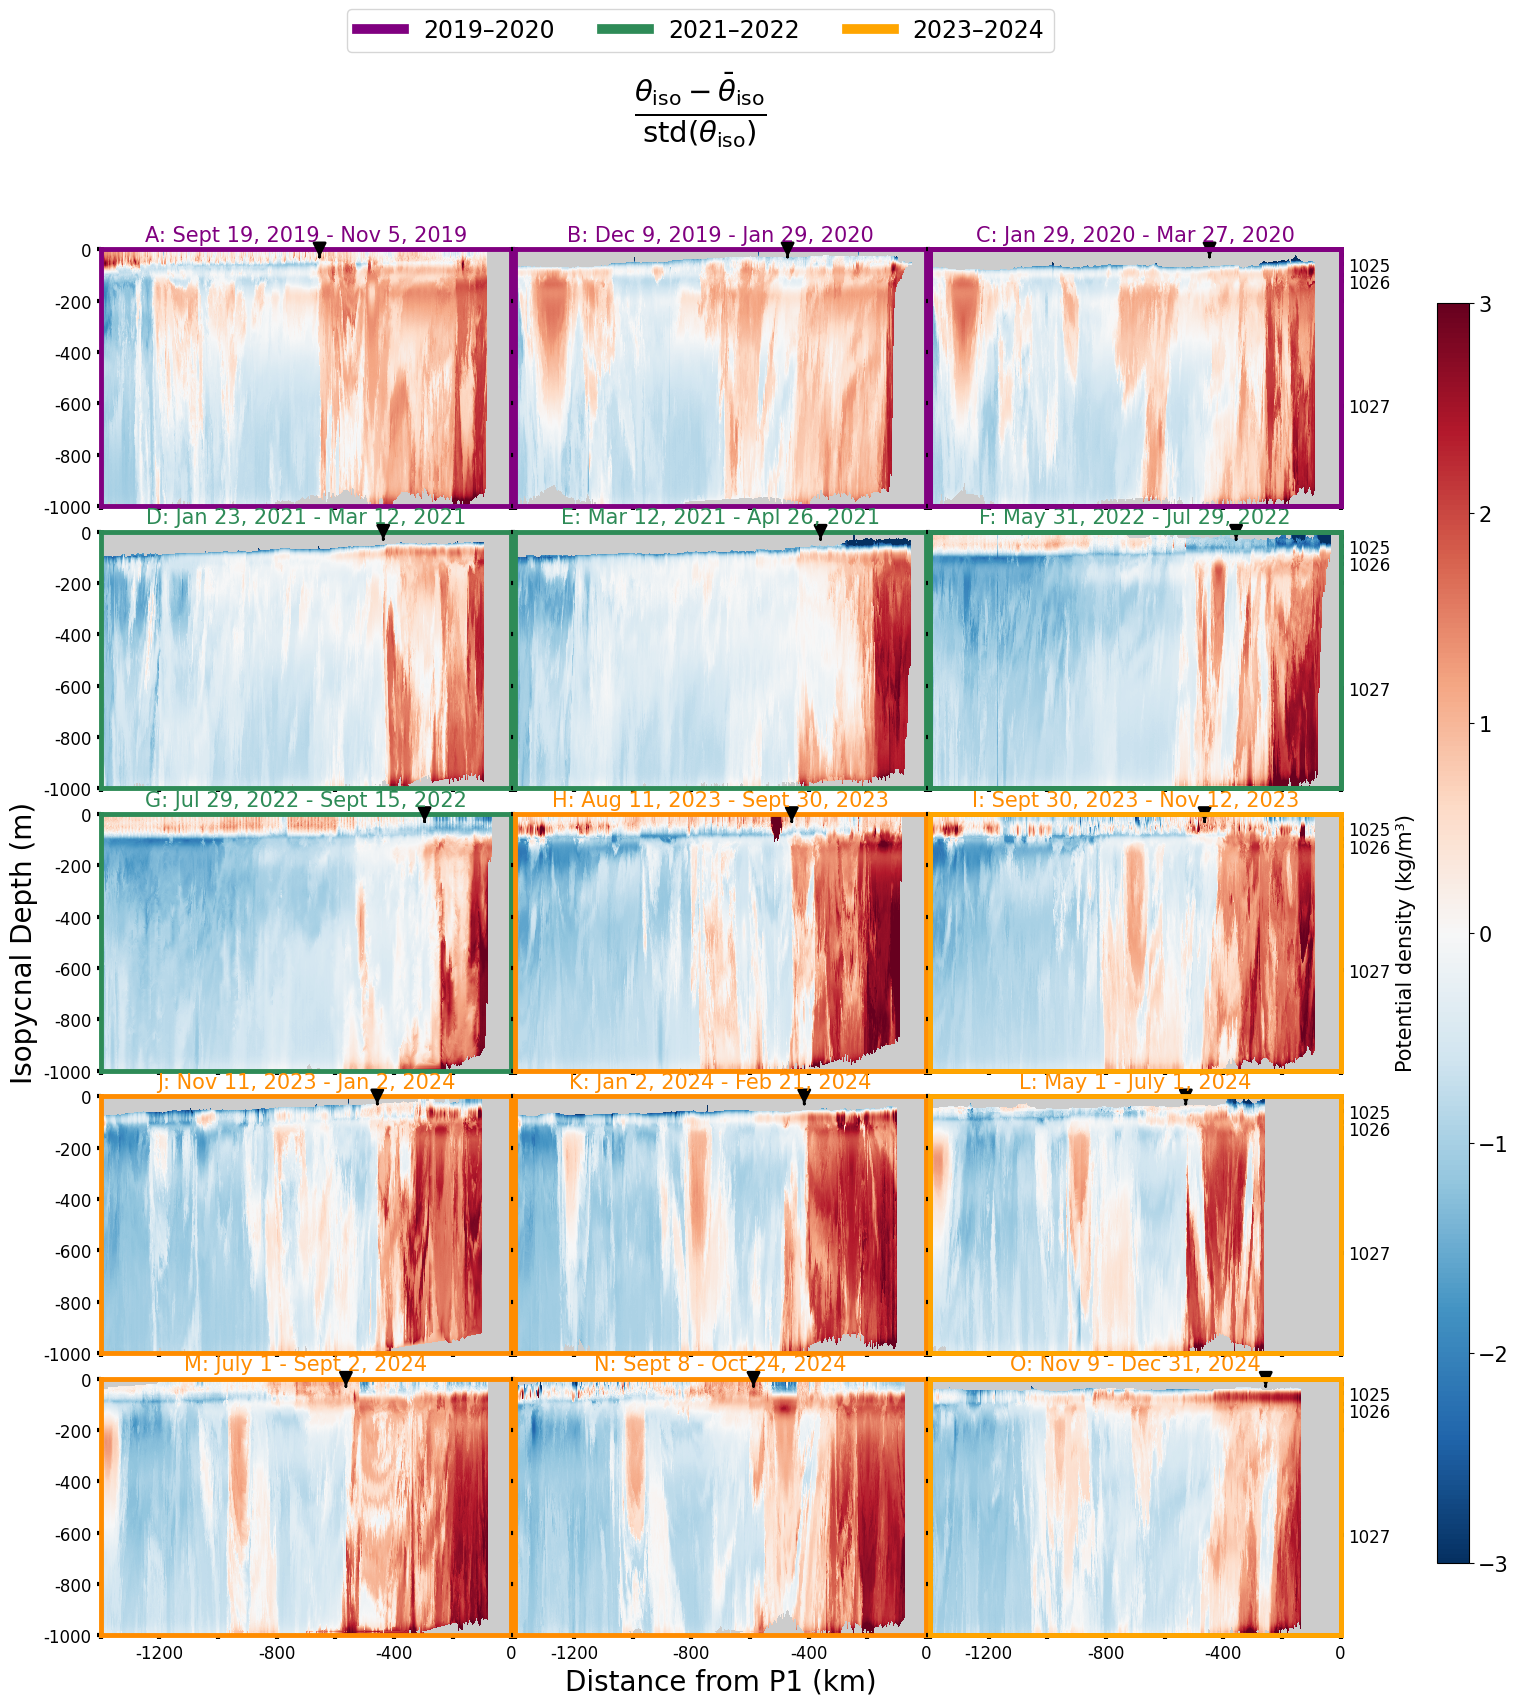

In [8]:
#open file with 15 glider missions 
all_sections_combined =  xr.open_dataset('/Users/Lauryn/THESIS/CPROOF_Work/Files/good_files/all_files15.nc')

def anomaly_plot_all(section, title, ax):
    vmin, vmax = -3, 3

    im = ax.pcolormesh(section.distance, -section.depth, 
                       ((section.iso_temps - all_sections_combined.pot_temp_mean) / 
                       all_sections_combined.pot_temp_std).T, cmap='RdBu_r', vmin=vmin, vmax=vmax, rasterized=True)

    ax.set_title(title, color='black',fontsize=15)
        
    ax.set_ylim(-1000,0)
    ax.set_xlim(-1400,0)

    return im

def extension_func(file):
    data = ((file.iso_temps-file.pot_temp_mean)/file.pot_temp_std).mean('depth')
    anom1=data[~np.isnan(data)]
    idx=0
    for i in range(len(data)-1):
        
        if data[i + 1] < 0 and data[i] >= 0: #find where theta^* switches from positive to negative 
            idx=(file.distance[i])
            break

    return idx.values

extension = []
for i in range(15):
    extension.append(extension_func(all_sections_combined.isel(file=i,depth=slice(110,920)))) 
    ##only use deoth range where there is data in all sections 
    
#find depths where iso_density is 1024.5 - 1027.2 
check_values = np.arange(1024.5,1027.5,0.5)
depth_ind=[]

for i in range(len(check_values)):
    absolute_differences = np.abs(all_sections_combined.iso_density[:,0] - check_values[i]).argmin()
    depth_ind.append(-absolute_differences.values)
    
######## Plot
fig, axs = plt.subplots(5, 3, figsize=(16,18), sharex=True, sharey=True, 
                        subplot_kw={'facecolor': '0.8'})
fig.subplots_adjust(hspace=0.1, wspace=0.01)

titles = ['A: Sept 19, 2019 - Nov 5, 2019', 'B: Dec 9, 2019 - Jan 29, 2020', 
          'C: Jan 29, 2020 - Mar 27, 2020', 'D: Jan 23, 2021 - Mar 12, 2021',
          'E: Mar 12, 2021 - Apl 26, 2021', 'F: May 31, 2022 - Jul 29, 2022', 
          'G: Jul 29, 2022 - Sept 15, 2022', 'H: Aug 11, 2023 - Sept 30, 2023', 
          'I: Sept 30, 2023 - Nov 12, 2023', 'J: Nov 11, 2023 - Jan 2, 2024',
          'K: Jan 2, 2024 - Feb 21, 2024','L: May 1 - July 1, 2024','M: July 1 - Sept 2, 2024',
         'N: Sept 8 - Oct 24, 2024', 'O: Nov 9 - Dec 31, 2024']



ims = []

# Plotting the data
for i in range(15):  # 13 subplots, matching the number of file_sections and titles
    ax = axs.flat[i]
    im = anomaly_plot_all(all_sections_combined.isel(file=i), titles[i], ax)  # Assuming this function is defined
    ax.annotate('', xy=(extension[i], -30), xytext=(extension[i], -29),
             arrowprops=dict(facecolor='black', arrowstyle='-|>', shrinkA=0, shrinkB=5,mutation_scale=20, linewidth=2))

    ims.append(im)

for i in range(15):  # Last row should have x-ticks
    axs.flat[i].set_xticks(axs.flat[i].get_xticks())  # Ensure x-ticks are shown
    axs.flat[i].set_xticklabels(axs.flat[i].get_xticklabels())
    axs.flat[i].tick_params(labelsize=12)
    axs.flat[i].set_xticks([0, -200, -400, -600, -800, -1000, -1200, -1400])  # Ensure x-ticks are shown
    axs.flat[i].set_xticklabels([0, '', -400,'' , -800, '', -1200,""])
    axs.flat[i].xaxis.set_tick_params(which='both', size=3, width=3)
    
for i in range(15):  # First column should have y-ticks
    axs.flat[i].set_yticks(axs.flat[i].get_yticks())  # Ensure y-ticks are shown
    axs.flat[i].set_yticklabels(axs.flat[i].get_yticklabels())
    axs.flat[i].tick_params(labelsize=12)
    axs.flat[i].yaxis.set_tick_params(which='both', size=3, width=3)
    axs.flat[i].set_yticks([0, -200, -400, -600, -800, -1000])  # Ensure y-ticks are shown
    axs.flat[i].set_yticklabels([0, -200, -400, -600, -800, -1000]) 

#### Add potential pressure on right side of plots     
for i in range(15):
    if i in [2,5,8,11,14]:
        axs2 = axs.flat[i].twinx()

        # Copy ticks
        axs2.set_yticks(axs.flat[i].get_yticks())
        axs2.set_yticklabels(axs.flat[i].get_yticklabels())
        axs2.tick_params(labelsize=12)
        axs2.yaxis.set_tick_params(which='both', size=2, width=3)
        axs2.set_yticks(np.flip(depth_ind))
        axs2.set_yticklabels(np.flip(['', 1025, '', 1026, '', 1027]))

        # Set label if needed
        if i == 8:
            axs2.set_ylabel('Potential density (kg/m³)', fontsize=15)

        # === NEW: Color the twin axis spines the same way ===
        if i <= 2:
            color = 'purple'
        elif i <= 6:
            color = 'seagreen'
        else:
            color = 'orange'
        
        for spine in axs2.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3.5)

        
    
# Add a colorbar
cbar_ax = fig.add_axes([0.96, 0.15, 0.02, 0.7])  # Adjust the size of the colorbar axis
cbar = fig.colorbar(ims[0], cax=cbar_ax)  # Colorbar associated with the first plot
cbar.ax.tick_params(labelsize=15)

spine_colors = ['purple', 'seagreen', 'darkorange']

for i, ax in enumerate(axs.flat[:15]):
    if i <= 2:
        color = spine_colors[0]  # 0-2
    elif i <= 6:
        color = spine_colors[1]  # 3-6
    else:
        color = spine_colors[2]  # 7-14

    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(3.5)
        
custom_lines = [Line2D([0], [0], color='purple', lw=7),
                Line2D([0], [0], color='seagreen', lw=7),
                Line2D([0], [0], color='orange', lw=7)]

fig.legend(custom_lines, ['2019–2020', '2021–2022', '2023–2024'], 
           loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=3, fontsize=17)

for i, ax in enumerate(axs.flat[:15]):
    if i <= 2:
        color = spine_colors[0]  # 0–2
    elif i <= 6:
        color = spine_colors[1]  # 3–6
    else:
        color = spine_colors[2]  # 7–14

    # Set the title color only
    ax.set_title(ax.get_title(), color=color, fontsize=15)

axs.flat[13].set_xlabel('Distance from P1 (km)', fontsize=20)  # Example
axs[2, 0].set_ylabel('Isopycnal Depth (m)', fontsize=20)
fig.suptitle(r'$ \frac{\theta_{\text{iso}} - \bar{\theta}_{\text{iso}}}{\text{std}(\theta_{\text{iso}})}$',
            fontsize=30)
plt.savefig("anoms.pdf", format="pdf", bbox_inches="tight", dpi=150)


## Figure 5 

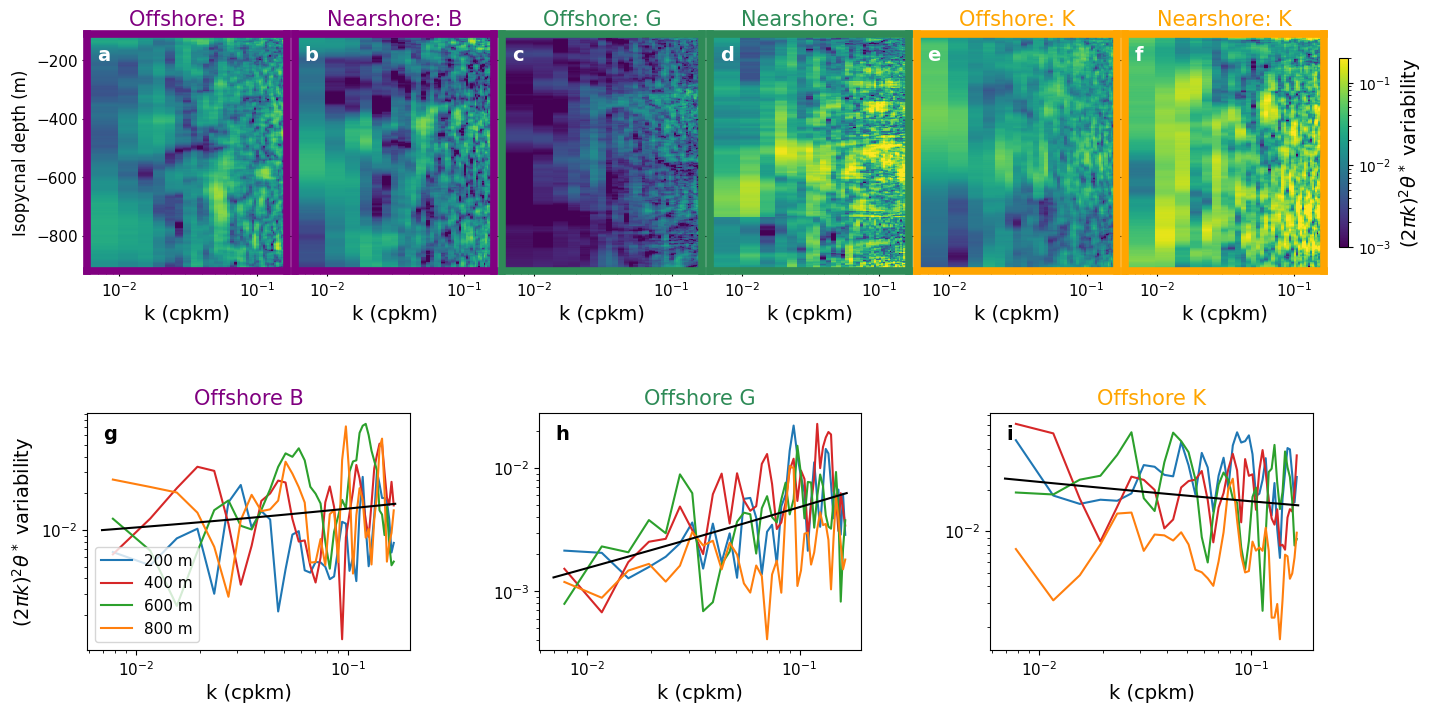

In [5]:
#Open file with transfer functions
transfer_path = '/Users/Lauryn/THESIS/CPROOF_Work/Files/transfer_functions/'

transfer = [ 'walle2019_jul_WE_transfer_functions.nc', 'walle2019_dec_EW_transfer_functions.nc',
            'walle2019_dec_WE_transfer_functions.nc','walle2021_EW_transfer_functions.nc',
            'walle2021_WE_transfer_functions.nc','rosie2022_EW_transfer_functions.nc',
            'rosie2022_WE_transfer_functions.nc','rosie2023_EW_transfer_functions.nc', 
            'rosie2023_WE_transfer_functions.nc','walle2023_EW_transfer_functions.nc', 
            'walle2023_WE_transfer_functions.nc','rosie2024_EW_transfer_functions.nc',
            'rosie2024_WE_transfer_functions.nc','walle2024_EW_transfer_functions.nc', 
            'walle2024_EW_transfer_functions.nc']

#Open files with theta^* sepctra 
all_spectra = xr.open_dataset('all_spectra.nc')
off_spectra = xr.open_dataset('off_spectra.nc')
near_spectra = xr.open_dataset('near_spectra.nc')


c = ['purple', 'seagreen', 'orange']
target_files = [1, 6, 10] #examples for each time bin 
depths = [200, 400, 600, 800] 
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange']
titles_row2 = ['Offshore B', 'Offshore G', 'Offshore K']
titles_row3 = ['A–C: 2019–2020', 'D–G: 2021–2022', 'H–O: 2023–2024']
mission = ['A', 'B', 'C', 'D', 'E', 'F',
           'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']

def linear_regression(k, PSD):
    k_best_fit = np.linspace(1 / 144, 1/6, 41)
    PSD_fit = np.interp(k_best_fit, k, PSD)
    
    lx, ly = [[math.log10(V) for V in v] for v in (k_best_fit, PSD_fit)]
    n = len(k_best_fit)
    sum_x = sum(x for x in lx)
    sum_y = sum(y for y in ly)
    sum_x2 = sum(x**2 for x in lx)
    sum_y2 = sum(y**2 for y in ly)
    sum_xy = sum(x * y for x, y in zip(lx, ly))

    # coefficients of a straight line "y = a + b x" in log-log space
    b = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x**2)
    a = (sum_y - b * sum_x) / n
    A = pow(10, a)

    y_log_pred = [a + b * x for x in lx]  # Predicted values in log space
    y_log_residuals = [(y - y_pred) for y, y_pred in zip(ly, y_log_pred)]
    y_log_residuals_squared = [res**2 for res in y_log_residuals]

    # Sum of squared residuals in log-log space
    y_log_yi2 = sum(y_log_residuals_squared)

    # Compute error of the slope
    error_slope = math.sqrt(y_log_yi2 / (n - 2))
    
    return A, b, error_slope, k_best_fit




#### Plot with gridspec 
fig = plt.figure(figsize=(19, 8))

# Top: full-width 6 columns, bottom: nested layout in columns 1–4
outer_gs = gridspec.GridSpec(2, 6, height_ratios=[2, 2], hspace=0.6, wspace=0.04)

# === Row 1: Full-width
axs1 = [fig.add_subplot(outer_gs[0, i]) for i in range(6)]

ims = []

for idx, file_idx in enumerate(target_files):
    col = idx * 2
    color = c[0] if file_idx <= 2 else (c[1] if file_idx <= 6 else c[2])

    # Offshore
    ax_off = axs1[col]
    spec_off = off_spectra.sel(file=file_idx, depth=slice(110, 920), k=slice(1/128, 1/6)) 
    im = ax_off.pcolormesh(spec_off.k, -spec_off.depth, spec_off.spectra * (2 * np.pi * spec_off.k)**2,
                           norm='log', vmin=1e-3, vmax=2e-1, rasterized=True)
    ax_off.set_xscale('log')
    ax_off.set_title(f'Offshore: {mission[file_idx]}', fontsize=15, color=color)
    ax_off.tick_params(labelsize=11)
    if idx == 0:
        ax_off.set_ylabel("Isopycnal depth (m)", fontsize=12)
    else:
        ax_off.set_yticklabels([])
    for spine in ax_off.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(5.5)
    ims.append(im)

    # Nearshore
    ax_near = axs1[col + 1]
    spec_near = near_spectra.sel(file=file_idx, depth=slice(110, 920), k=slice(1/128, 1/6))
    im = ax_near.pcolormesh(spec_near.k, -spec_near.depth, spec_near.spectra * (2 * np.pi * spec_near.k)**2,
                            norm='log', vmin=1e-3, vmax=2e-1, rasterized=True)
    ax_near.set_xscale('log')
    ax_near.set_title(f'Nearshore: {mission[file_idx]}', fontsize=15, color=color)
    ax_near.set_yticklabels([])
    ax_near.tick_params(labelsize=11)
    for spine in ax_near.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(5.5)
    ims.append(im)

# === ROW 2: Center-aligned Slope Fits ===
inner_gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_gs[1, 0:5], wspace=0.4)
axs2 = [fig.add_subplot(inner_gs2[0, i]) for i in range(3)]

for j, file_idx in enumerate(target_files):
    gr1_slope = []
    for i, dpth in enumerate(depths):
        gr1 = off_spectra.isel(file=file_idx, depth=dpth).sel(k=slice(1/300, 1/6))
        A1, b1, err, k_fit = linear_regression(gr1.k, gr1.spectra * (2 * np.pi * gr1.k)**2)
        gr1_slope.append([A1 * pow(x, b1) for x in k_fit])
        axs2[j].loglog(gr1.k, gr1.spectra * (2 * np.pi * gr1.k)**2, c=colors[i], label=f'{dpth} m')
    axs2[j].plot(k_fit, np.mean(gr1_slope, axis=0), c='k')
    axs2[j].set_title(titles_row2[j], fontsize=15,c=c[j])
    axs2[j].tick_params(labelsize=11)

axs2[0].legend(fontsize=11, loc='lower left')

#=== Colorbar and Legend ===
cbar = fig.colorbar(ims[0], ax=axs1, orientation='vertical', pad=0.01, shrink=0.8)
cbar.ax.set_ylabel(r'$(2\pi k)^2 \theta^*$ variability', fontsize=14)


labels = ['a', 'c', 'e']
count=0
for ax in axs1[::2]:  # every left subplot in top row (Offshore)
    ax.set_xlabel('k (cpkm)', fontsize=14)
    ax.text(0.05, 0.95, labels[count], transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left',color='white')
    count+=1

labels = ['b', 'd', 'f']
count=0
for ax in axs1[1::2]:  # every right subplot in top row (Nearshore)
    ax.set_xlabel('k (cpkm)', fontsize=14)
    ax.text(0.05, 0.95, labels[count], transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left',color='white')
    count+=1

label=['g','h','i']
count=0
for ax in axs2:
    ax.set_xlabel('k (cpkm)', fontsize=14)
    ax.text(0.05, 0.95, label[count], transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left',color='k')
    count+=1


# Label y-axes clearly
axs2[0].set_ylabel(r'$(2\pi k)^2 \theta^*$ variability', fontsize=14)
axs =[axs1,axs2]

plt.savefig("spectra_nod.pdf", format="pdf", bbox_inches="tight")


## Figure 6

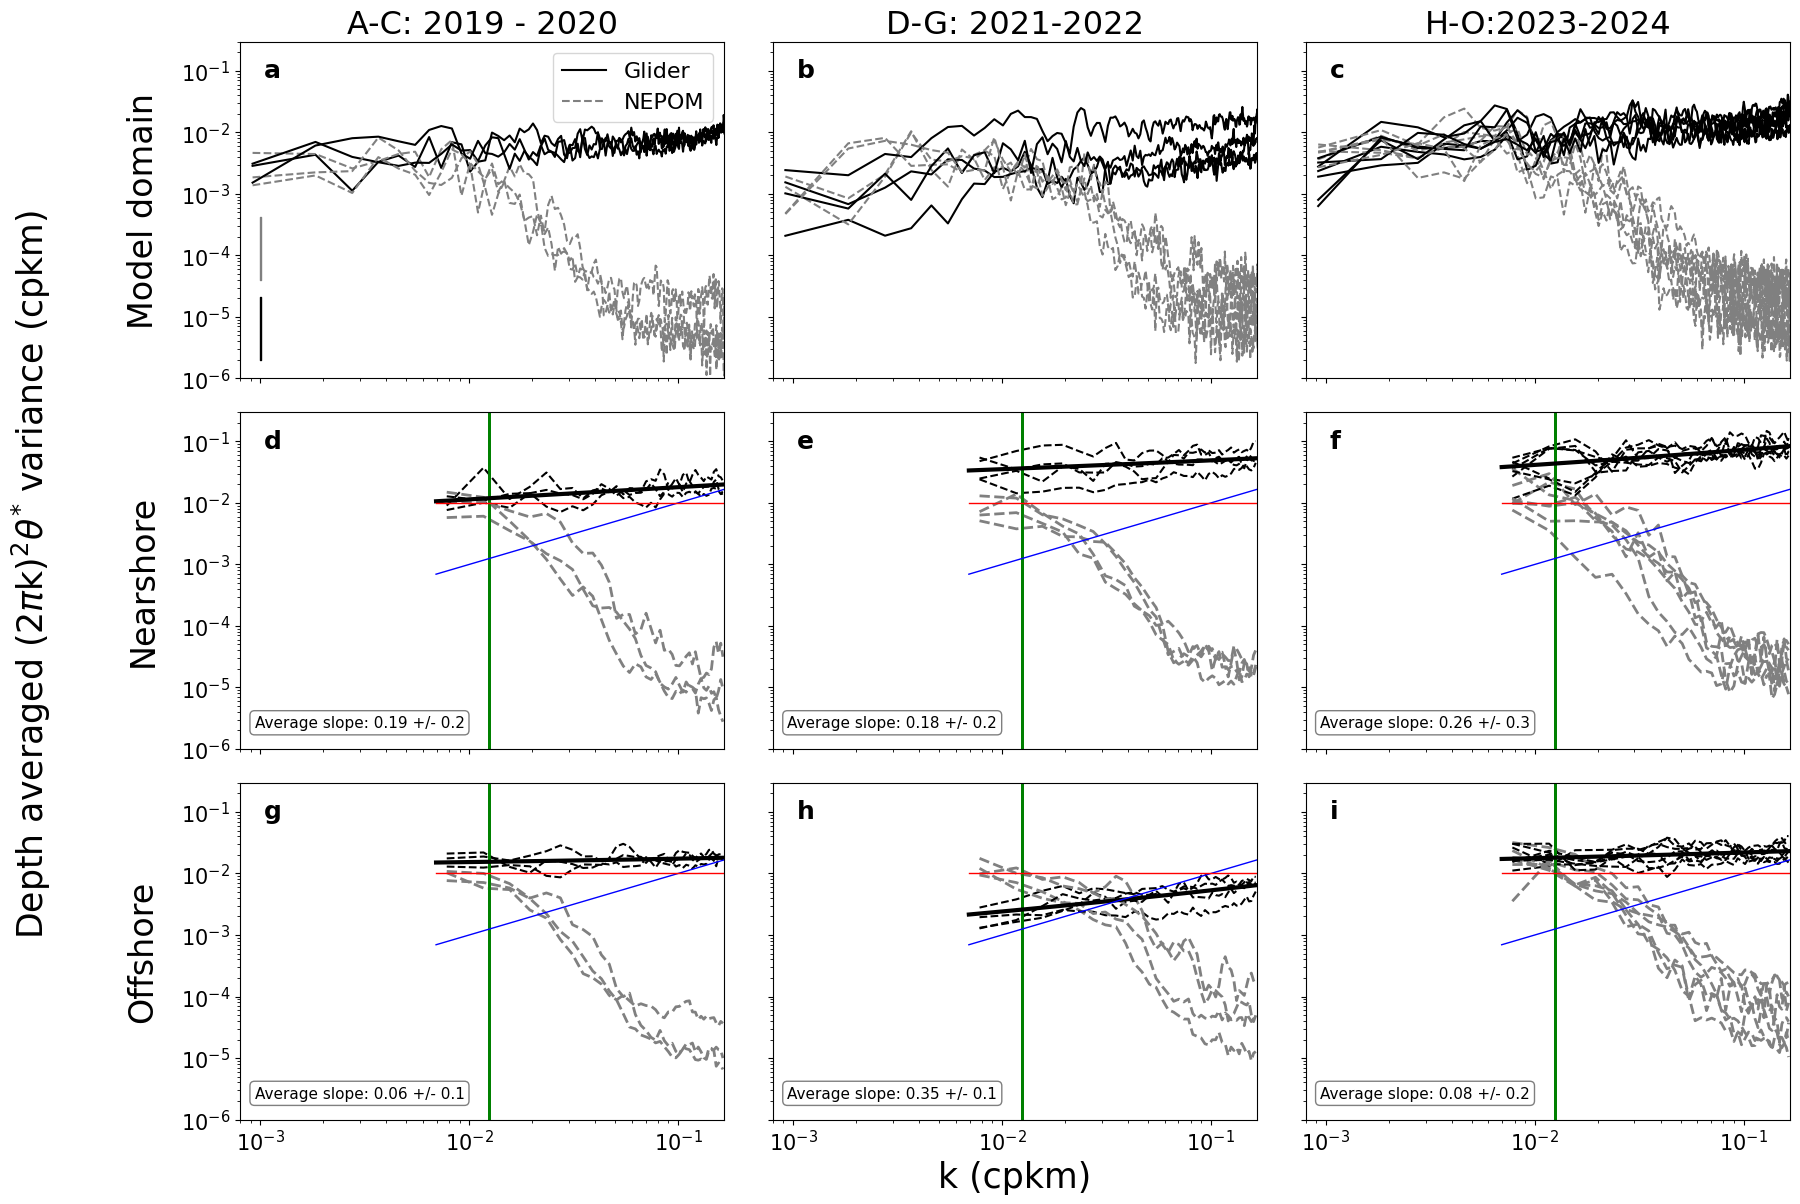

In [6]:
#Open files with theta^* sepctra 
all_spectra = xr.open_dataset('all_spectra.nc')
off_spectra = xr.open_dataset('off_spectra.nc')
near_spectra = xr.open_dataset('near_spectra.nc')

#Open NEPOM section files 
model_path = '/Users/Lauryn/THESIS/CPROOF_Work/NEPOM/'
all_synthetic = xr.open_dataset(model_path+'all_synthetic_files.nc')

#Open NEPOM spectra files 
mod_all_spectra= xr.open_dataset('mod_spectra_all.nc')
mod_near_spectra=xr.open_dataset('mod_near_spectra.nc')
mod_off_spectra=xr.open_dataset('mod_off_spectra.nc')
ds = xr.open_dataset('glider_spectra_confidence_bounds.nc')
ds2 = xr.open_dataset('model_spectra_confidence_bounds.nc')

def plot_spectra(file, ax, color="k", linestyle="-", label=None, ci=None, y_bottom=None, 
                 depth_range=(110, 920), k_range=None, add_error=False):
    """
    Plot depth-averaged spectra with optional confidence interval shading.
    """
    gr = file.sel(depth=slice(*depth_range))
    if k_range:
        gr = gr.sel(k=slice(*k_range))
        
    PSD_mean = gr.spectra.mean('depth')
    ax.loglog(gr.k, PSD_mean * (2*np.pi*gr.k)**2, c=color, ls=linestyle, label=label)

    # Add error shading if requested
    if add_error and ci is not None and y_bottom is not None:
        ci_lower = ci['ci_lower'].sel(file=file.file.values, depth=slice(*depth_range)).mean('depth')
        ci_upper = ci['ci_upper'].sel(file=file.file.values, depth=slice(*depth_range)).mean('depth')
        lower = ci_lower * (2*np.pi*gr.k.values)**2
        upper = ci_upper * (2*np.pi*gr.k.values)**2

        valid = np.isfinite(lower) & np.isfinite(upper)
        if valid.any():
            error_ratio = np.nanmean(upper[valid]) / np.nanmean(lower[valid])
            y_top = y_bottom * error_ratio
            ax.fill_between([1e-3, 1.01e-3], [y_bottom, y_bottom], [y_top, y_top],
                            color=color, zorder=2)


def plot_avg_line(ax, k_best_fit, slopes, intercepts, slope_errors, label="Average"):
    """
    Plot average regression line and annotate with slope and error.
    """
    slopes_da = xr.DataArray(slopes, dims=('section', 'k'))
    slope_mean = slopes_da.mean('section')

    ax.plot(k_best_fit, slope_mean, c='black', linewidth=3, label=label)
    error = np.sqrt(np.sum(slope_errors))
    txt = f'Average slope: {np.round(np.mean(intercepts), 2)} +/- {np.round(error, 1)}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.03, 0.1, txt, transform=ax.transAxes, fontsize=11,
            bbox=props, verticalalignment='top', c='k')

    # Reference slopes
    ax.plot(k_best_fit, k_best_fit**1 * 10**-1, c='blue', linewidth=1)
    ax.plot(k_best_fit, k_best_fit**0 * 10**-2, c='red', linewidth=1)

#Plot 

fig = plt.figure(figsize=(20, 14))
outer_gs = gridspec.GridSpec(3, 3, height_ratios=[2, 2, 2], hspace=0.1, wspace=0.03)

#Row 1: Model domain (3 panels)
inner_gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_gs[0, :], wspace=0.1)
axs1 = [fig.add_subplot(inner_gs1[0, i]) for i in range(3)]
for ax in axs1:
    ax.set_ylim(1e-6, 3e-1)
    ax.set_xlim(8e-4, 1/6)

plot_spectra(all_spectra.isel(file=0), axs1[0], color="k", linestyle="-", 
             label="Glider", ci=ds, y_bottom=2e-6, add_error=True)
plot_spectra(mod_all_spectra.isel(file=0), axs1[0], color="gray", linestyle="--", 
             label="NEPOM", ci=ds2, y_bottom=4e-5, add_error=True)

axs1[0].legend(loc='upper right', fontsize=16)

# Add additional spectra
for i in range(1, 3):
    plot_spectra(all_spectra.isel(file=i), axs1[0])
    plot_spectra(mod_all_spectra.isel(file=i), axs1[0], color="gray", linestyle="--")

for i in range(3, 7):
    plot_spectra(all_spectra.isel(file=i), axs1[1])
    plot_spectra(mod_all_spectra.isel(file=i), axs1[1], color="gray", linestyle="--")

for i in range(7, 14):
    plot_spectra(all_spectra.isel(file=i), axs1[2])
    plot_spectra(mod_all_spectra.isel(file=i), axs1[2], color="gray", linestyle="--")

titles = ['A-C: 2019 - 2020', 'D-G: 2021-2022', 'H-O:2023-2024']
for i, t in enumerate(titles):
    axs1[i].set_title(t, fontsize=23)

#Row 2: Nearshore (3 panels)
inner_gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_gs[1, :], wspace=0.1)
axs2 = [fig.add_subplot(inner_gs2[0, i]) for i in range(3)]
for ax in axs2:
    ax.set_ylim(1e-6, 3e-1)
    ax.set_xlim(8e-4, 1/6)

# Nearshore loop
for idx_group, ax in zip([range(0,3), range(3,7), range(7,14)], axs2):
    slopes, intercepts, slope_errors = [], [], []
    k_best_fit = None
    for i in idx_group:
        near = near_spectra.isel(file=i).sel(depth=slice(110,920), k=slice(1/128,1/6))
        mod = mod_near_spectra.sel(file=i, depth=slice(110,920), k=slice(1/128,1/6))
        # regression
        A, b, err, k_best_fit = linear_regression(near.k, near.spectra.mean("depth")*(2*np.pi*near.k)**2)
        ax.loglog(near.k, near.spectra.mean("depth")*(2*np.pi*near.k)**2, c="k", ls="--")
        slopes.append([A * pow(x, b) for x in k_best_fit])
        intercepts.append(b)
        slope_errors.append(err**2)
        # model
        ax.loglog(mod.k, mod.spectra.mean("depth")*(2*np.pi*mod.k)**2, c="gray", ls="--", linewidth=2)
        ax.axvline(x=1/80, linewidth=2, c="green")
    plot_avg_line(ax, k_best_fit, slopes, intercepts, slope_errors)

#Row 3: Offshore (3 panels)  
inner_gs3 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_gs[2, :], wspace=0.1)
axs3 = [fig.add_subplot(inner_gs3[0, i]) for i in range(3)]
for ax in axs3:
    ax.set_ylim(1e-6, 3e-1)
    ax.set_xlim(8e-4, 1/6)

for idx_group, ax in zip([range(0,3), range(3,7), range(7,14)], axs3):
    slopes, intercepts, slope_errors = [], [], []
    k_best_fit = None
    for i in idx_group:
        off = off_spectra.isel(file=i).sel(depth=slice(110,920), k=slice(1/128,1/6))
        mod = mod_off_spectra.sel(file=i, depth=slice(110,920), k=slice(1/128,1/6))
        A, b, err, k_best_fit = linear_regression(off.k, off.spectra.mean("depth")*(2*np.pi*off.k)**2)
        ax.loglog(off.k, off.spectra.mean("depth")*(2*np.pi*off.k)**2, c="k", ls="--")
        slopes.append([A * pow(x, b) for x in k_best_fit])
        intercepts.append(b)
        slope_errors.append(err**2)
        ax.loglog(mod.k, mod.spectra.mean("depth")*(2*np.pi*mod.k)**2, c="gray", ls="--", linewidth=2)
        ax.axvline(x=1/80, linewidth=2, c="green")
    plot_avg_line(ax, k_best_fit, slopes, intercepts, slope_errors)

#Labels

axs1[0].text(-0.2, 0.5, 'Model domain', fontsize=24, ha='center',rotation='vertical', va='center', transform=axs1[0].transAxes)
axs2[0].text(-0.2, 0.5, 'Nearshore', fontsize=24, ha='center',rotation='vertical', va='center', transform=axs2[0].transAxes)
axs3[0].text(-0.2, 0.5, 'Offshore', fontsize=24, ha='center',rotation='vertical', va='center', transform=axs3[0].transAxes)

fig.text(0.01, 0.50, r'Depth averaged (2$\pi$k)$^{2} \theta^{*}$ variance (cpkm)', 
         va='center', rotation='vertical', fontsize=25)
axs3[1].set_xlabel('k (cpkm)', fontsize=25) 

# Hide redundant labels
for ax in axs1 + axs2:
    ax.tick_params(labelbottom=False)
for row in [axs1, axs2, axs3]:
    for ax in row[1:]:
        ax.tick_params(labelleft=False)

# Subplot labels (a–i)
labels = list("abcdefghi")
for ax, lbl in zip(axs1+axs2+axs3, labels):
    ax.tick_params(labelsize=15)
    ax.text(0.05, 0.95, lbl, transform=ax.transAxes,
            fontsize=18, fontweight='bold', va='top', ha='left', color='k')

plt.savefig("spectra_all_scales.pdf", format="pdf", bbox_inches="tight")


## Figure 7

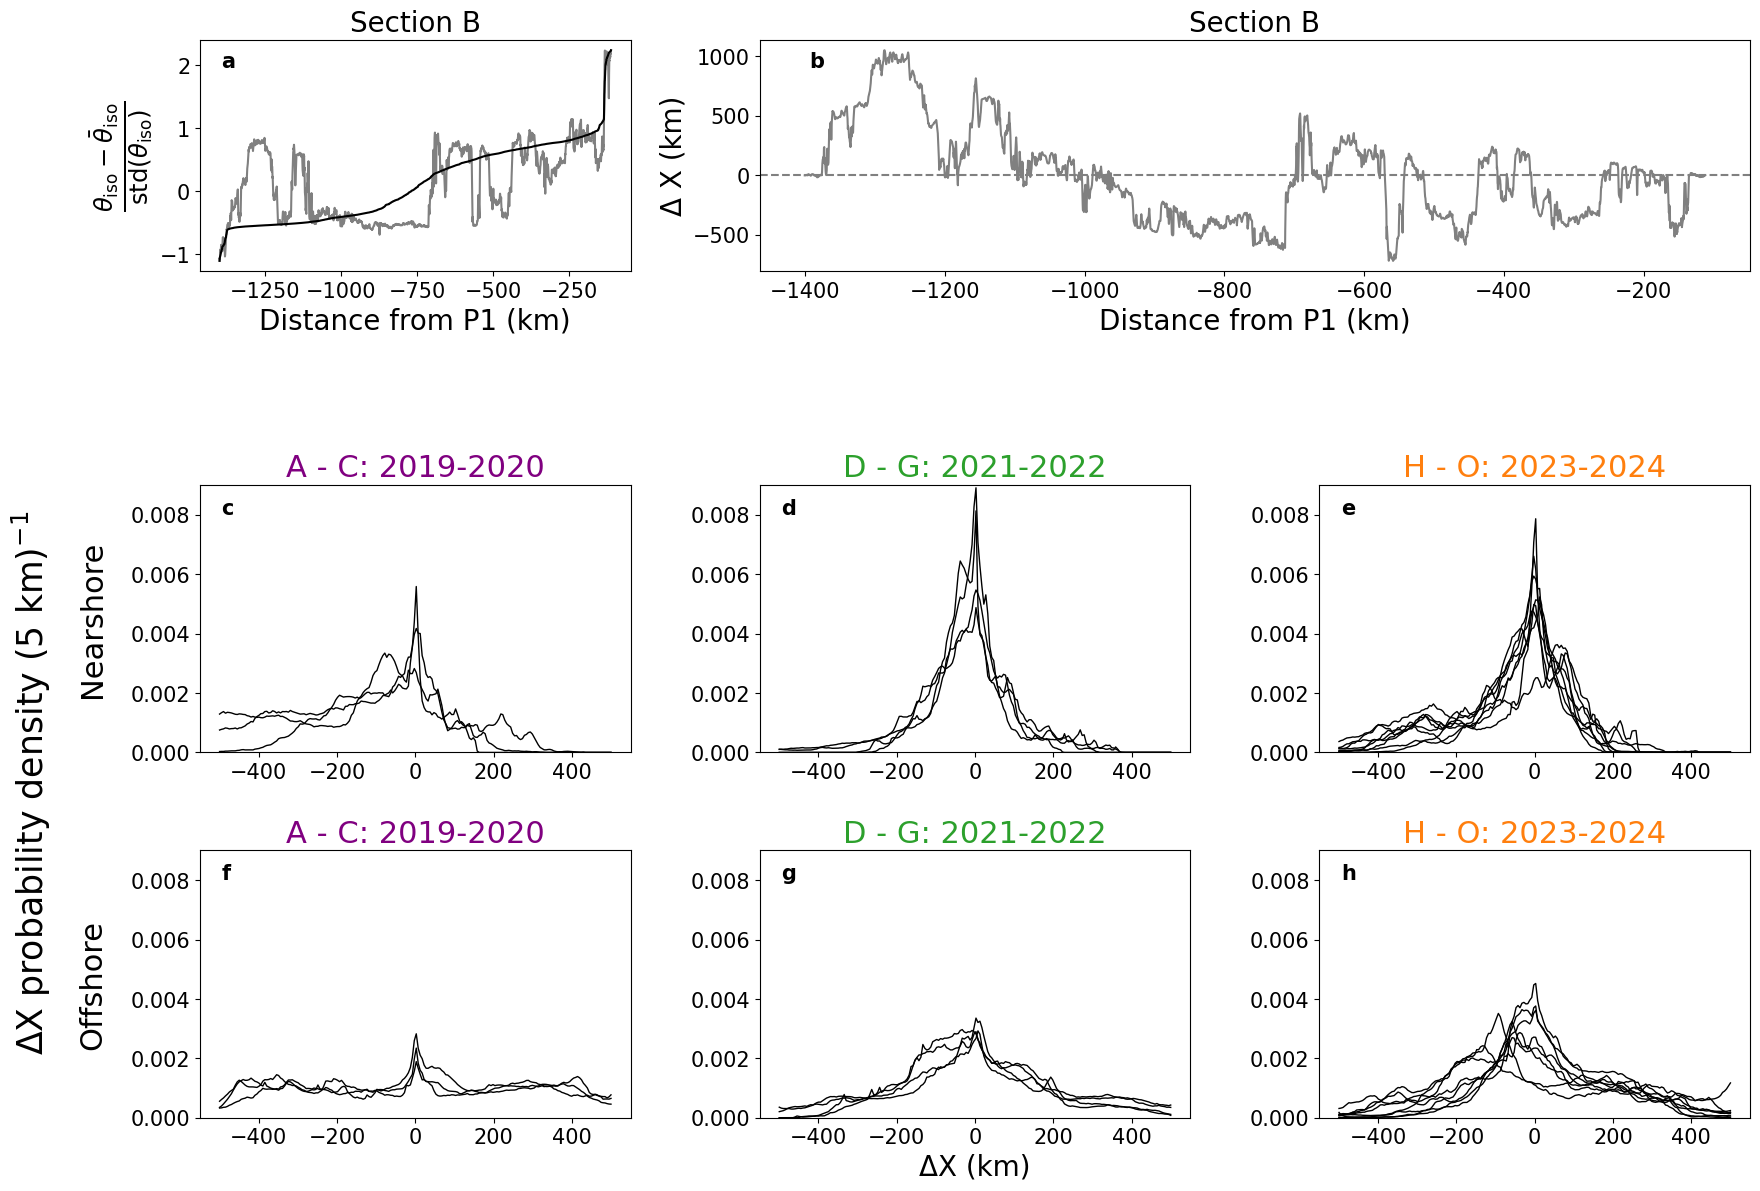

In [8]:
#open file with 15 glider missions 
all_sections_combined =  xr.open_dataset('/Users/Lauryn/THESIS/CPROOF_Work/Files/good_files/all_files15.nc')

#Select glider Section B as an example 
section=all_sections_combined.isel(file=1)

### Example of lateral displacements code 
i=500 #500 m depth 
vals=(section.iso_temps.T[i].values- all_sections_combined.pot_temp_mean[i].values)/all_sections_combined.pot_temp_std[i].values
good_inx = (~np.isnan(vals)) 
vals_nonan = vals[good_inx]
idx_sort =vals_nonan.argsort()[::-1]
sorted_vals = vals_nonan[idx_sort]


if (len(sorted_vals)>1): 
    closest_indices = np.empty(len(vals), dtype=int)

    # Iterate through each element in the smaller array
    for j, val in enumerate(vals):
            # Calculate the absolute differences and find the index of the minimum difference
            closest_index = np.abs( sorted_vals-val).argmin()
            # Store the closest index in the result array
            closest_indices[j] = int(closest_index)

    new_x = np.empty(len(section.distance))     
    new_x[:]=np.nan
    new_x[good_inx ]= section.distance[good_inx][closest_indices[good_inx]]

lat_disp =  new_x - section.distance.values 

#Open file with all lateral displacements
all_lat_disp=xr.open_dataset('/Users/Lauryn/THESIS/CPROOF_Work/Files/good_files/all_files_lat_disp15.nc')
near_lat_disp =  all_lat_disp.sel(distance=slice(0,-550))
off_lat_disp =  all_lat_disp.sel(distance=slice(-550,-1550))

###Plot 
fig = plt.figure(figsize=(20, 14))

# Use 4 rows: section plots, spacer, nearshore hist, offshore hist
gs = gridspec.GridSpec(4, 3, height_ratios=[1.3, 0.1, 1.5, 1.5], wspace=0.3, hspace=0.5)

# Top row: 2 centered section plots, each ~1.5 cols wide ===
axs_section0 = fig.add_subplot(gs[0, 0:1])
axs_section1 = fig.add_subplot(gs[0, 1:3])

# Plot section 0
axs_section0.plot(section.distance, vals, c='gray')
axs_section0.plot(section.distance[good_inx], sorted_vals, c='k')
axs_section0.set_ylabel(r'$ \frac{\theta_{\text{iso}} - \bar{\theta}_{\text{iso}}}{\text{std}(\theta_{\text{iso}})}$',
                        fontsize=25)
axs_section0.tick_params(axis='both', labelsize=15)
axs_section0.text(0.05, 0.95, 'a', transform=axs_section0.transAxes,
                  fontsize=15, fontweight='bold', va='top', ha='left')
axs_section0.set_xlabel('Distance from P1 (km)', fontsize=20)
axs_section0.set_title('Section B', fontsize=20)

# Plot section 1
axs_section1.plot(section.distance, lat_disp, c='gray')
axs_section1.axhline(y=0, c='gray', ls='--')
axs_section1.set_ylabel(u'Δ X (km)', fontsize=20)
axs_section1.set_xlabel('Distance from P1 (km)', fontsize=20)
axs_section1.tick_params(axis='both', labelsize=15)
axs_section1.text(0.05, 0.95, 'b', transform=axs_section1.transAxes,
                  fontsize=15, fontweight='bold', va='top', ha='left')
axs_section1.set_title('Section B', fontsize=20)

# === Histogram axes (2 rows × 3 cols) ===
axs_hist = np.empty((2, 3), dtype=object)
new_titles = ['A - C: 2019-2020', 'D - G: 2021-2022', 'H - O: 2023-2024']
i_vals = [[0,1,2], [3,4,5,6], [7,8,9,10,11,12,13,14]]
c = ['purple', 'tab:green', 'tab:orange']
labels = ['c', 'd', 'e', 'f', 'g', 'h']

for row in range(2):
    for col in range(3):
        axs_hist[row, col] = fig.add_subplot(gs[row + 2, col])  # rows 2 and 3 (nearshore, offshore)

# Plot nearshore  
for i in range(3):
    for j in range(len(i_vals[i])):
        all_ = near_lat_disp.isel(file=i_vals[i][j]).isel(depth=slice(110, 920)).__xarray_dataarray_variable__
        x = np.linspace(-500, 500, 200)
        bins = np.linspace(-500, 500, 201)
        hist_all, _ = np.histogram(all_, bins=bins, density=True)
        axs_hist[0, i].plot(x, hist_all, c='black', linewidth=1)

    axs_hist[0, i].tick_params(axis='x', labelsize=15)
    axs_hist[0, i].tick_params(axis='y', labelsize=15)
    axs_hist[0, i].set_ylim(0, 0.009)
    axs_hist[0, i].set_title(new_titles[i], fontsize=22, color=c[i])
    axs_hist[0, i].text(0.05, 0.95, labels[i], transform=axs_hist[0, i].transAxes,
                        fontsize=15, fontweight='bold', va='top', ha='left')

#  Plot offshore 
for i in range(3):
    for j in range(len(i_vals[i])):
        all_ = off_lat_disp.isel(file=i_vals[i][j]).isel(depth=slice(110, 920)).__xarray_dataarray_variable__
        x = np.linspace(-500, 500, 200)
        bins = np.linspace(-500, 500, 201)
        hist_all, _ = np.histogram(all_, bins=bins, density=True)
        axs_hist[1, i].plot(x, hist_all, c='black', linewidth=1)

    axs_hist[1, i].tick_params(axis='x', labelsize=15)
    axs_hist[1, i].tick_params(axis='y', labelsize=15)
    axs_hist[1, i].set_ylim(0, 0.009)
    axs_hist[1, i].set_title(new_titles[i], fontsize=22, color=c[i])
    axs_hist[1, i].set_title(new_titles[i], fontsize=22, color=c[i])
    axs_hist[1, i].text(0.05, 0.95, labels[i+3], transform=axs_hist[1, i].transAxes,
                        fontsize=15, fontweight='bold', va='top', ha='left')

#Labels 
axs_hist[1, 1].set_xlabel(u"ΔX (km)", fontsize=20)
axs_hist[0, 0].text(-0.25, 0.5, 'Nearshore', fontsize=22, ha='center', rotation='vertical',
                    va='center', transform=axs_hist[0, 0].transAxes)
axs_hist[1, 0].text(-0.25, 0.5, 'Offshore', fontsize=22, ha='center', rotation='vertical',
                    va='center', transform=axs_hist[1, 0].transAxes)

fig.text(0.03, 0.35, r'ΔX probability density (5 km)$^{-1}$', va='center', rotation='vertical', fontsize=25)


plt.savefig("lat_disp_combined.pdf", format="pdf", bbox_inches="tight")
plt.show()



## Figure 8

In [ ]:
dist_path = '/Users/Lauryn/THESIS/CPROOF_Work/Files/corrected_location/'#path for uninterpolated data
DEPTH_MIN = 110
DEPTH_MAX = 920             
DEPTH_RANGE = range(DEPTH_MIN, DEPTH_MAX)   
DIST_SPLIT = -550         # offshore/nearshore boundary
BINS = np.arange(-3, 3.5, 0.03)

#open file with 15 glider missions 
all_sections_combined =  xr.open_dataset('/Users/Lauryn/THESIS/CPROOF_Work/Files/good_files/all_files15.nc')
#Open file with 15 simulated NEPOM missions
all_synthetic = xr.open_dataset('/Users/Lauryn/THESIS/CPROOF_Work/NEPOM/all_synthetic_files.nc')


def open_ds_list(names):
    out = []
    for n in names:
        out.append(xr.open_dataset(f"{dist_path}{n}_corrected_dist.nc"))
    return out

def interpolate_iso_temps(ds, all_sections):
    pot_rho = gsw.pot_rho_t_exact(ds.salinity, ds.potential_temperature, ds.pressure, 0)
    rows = []
    nt = ds.sizes['time']
    for i in range(nt):
        x  = np.array(all_sections.iso_density.isel(distance=i))
        xp = np.array(pot_rho.isel(time=i))
        yp = np.array(ds.potential_temperature.isel(time=i))
        rows.append(np.interp(x, xp, yp, left=np.nan, right=np.nan))
    return xr.DataArray(
        rows,
        dims=("time","depth"),
        coords={"time": ds.time, "depth": ds.depth, "distance": ds.v_distance},
        name="iso_temps"
    )

def flatten_for_hist(anom):
    if "time" in anom.dims:
        flat = anom.stack(_f=("time",)).values
    elif {"file","distance"} <= set(anom.dims):
        flat = anom.stack(_f=("file","distance")).values
    elif "distance" in anom.dims:
        flat = anom.stack(_f=("distance",)).values
    else:
        raise ValueError(f"Unexpected dims for histogram: {anom.dims}")
    flat = flat[~np.isnan(flat)]
    return flat

def compute_histograms(group_data, bins, all_sections, depth_min=DEPTH_MIN, depth_max=DEPTH_MAX):

    depth_count = depth_max - depth_min
    hist_out = np.full((depth_count, len(bins)-1), np.nan)

    for j_abs in range(depth_min, depth_max):
        j_rel = j_abs - depth_min
        temps = group_data.isel(depth=j_abs)

        mean = all_sections.isel(depth=j_abs).pot_temp_mean.values
        std  = all_sections.isel(depth=j_abs).pot_temp_std.values
        anom = (temps - mean) / std

        flat = flatten_for_hist(anom)
        if flat.size > 0:
            psd, _ = np.histogram(flat, bins=bins, density=True)
            hist_out[j_rel, :] = psd

    hist_out = np.expand_dims(hist_out, axis=0)  # (1, depth_count, bins-1)
    return np.where(hist_out == 0, np.nan, hist_out)


######## Example for section B

def dist_mission(file, bins=np.arange(-3, 3.5, 0.03), depth_min=110, depth_max=920):
    subsets = [
        file,
        file.where(file.distance < -550, drop=True),
        file.where(file.distance > -550, drop=True),
    ]
    depth_count = depth_max - depth_min
    all_hist = np.full((3, depth_count, len(bins) - 1), np.nan)

    def get_anom(data, j, use_slice=True):
        """Return standardized anomalies at depth j."""
        temps = data.isel(depth=j).iso_temps
        if use_slice:
            ref = all_sections_combined.sel(distance=slice(-80, -1200)).isel(depth=j)
        else:
            ref = all_sections_combined.isel(depth=j)
        mean, std = ref.pot_temp_mean.values, ref.pot_temp_std.values
        anom = (temps - mean) / std
        return anom[~np.isnan(anom)]

    # First pass: determine full weights from the whole file
    full_weights = []
    for j in range(depth_min, depth_max):
        anom = get_anom(file, j, use_slice=True)
        w = np.ones_like(anom) / len(anom) if anom.size > 0 else np.array([])
        full_weights.append(w)

    # Second pass: histograms for each subset
    for i, data in enumerate(subsets):
        for j in range(depth_min, depth_max):
            anom = get_anom(data, j, use_slice=False)
            if anom.size > 0:
                # broadcast the full weight to subset size
                weights = np.ones_like(anom) / max(len(full_weights[j - depth_min]), 1)
                psd, _ = np.histogram(anom, bins=bins, weights=weights)
                all_hist[i, j - depth_min, :] = psd

    return all_hist


b_hist = dist_mission(all_sections_combined.isel(file=1))
b_hist_mod = dist_mission(all_synthetic.isel(file=1))



####### Histograms

bins = np.arange(-3, 3.5, 0.03)
depth_range = range(110, 920)

# Glider groups
group_names = {
    "2019":    ["walle2019_jul_WE", "walle2019_dec_EW", "walle2019_dec_WE"],
    "2021-22": ["walle2021_EW", "walle2021_WE", "rosie2022_EW", "rosie2022_WE"],
    "2023-24": ["rosie2023_EW", "rosie2023_WE", "walle2023_EW", "walle2023_WE",
                "rosie2024_EW", "rosie2024_WE", "walle2024_EW", "walle2024_WE"],
}
datasets = {k: open_ds_list(v) for k, v in group_names.items()}

# Interpolate all to iso-density space (DataArray list)
iso_temps = []
for k in group_names:
    for ds in datasets[k]:
        iso_temps.append(interpolate_iso_temps(ds, all_sections_combined))

gps = [iso_temps[0:3], iso_temps[3:7], iso_temps[7:15]]
all_hist_glider = np.full((3, len(DEPTH_RANGE), len(BINS)-1), np.nan)

for group_idx in range(3):
    group_data = xr.concat(gps[group_idx], dim="time")
    all_hist_glider[group_idx] = compute_histograms(
    group_data, bins, all_sections_combined,
    depth_min=depth_range.start, depth_max=depth_range.stop)
    
# NEPOM groups
file_slices = [slice(0, 3), slice(3, 6), slice(7, 14)]
all_hist = np.full((3, len(DEPTH_RANGE), len(BINS)-1), np.nan)

for group_idx, sl in enumerate(file_slices):
    group_data = xr.concat(all_synthetic.isel(file=sl).iso_temps, dim="distance")
    all_hist[group_idx] = compute_histograms(
    group_data, bins, all_sections_combined,
    depth_min=depth_range.start, depth_max=depth_range.stop)

# Density index
check_values = np.arange(1024.5, 1027.5, 0.5)
depth_ind = [-(np.abs(all_sections_combined.iso_density[:,0] - val).argmin().values) for val in check_values]


######### Plot 
fig = plt.figure(figsize=(16, 18))   
gs = gridspec.GridSpec(
    4, 2, height_ratios=[1, 1, 1, 1.3],
    hspace=0.4, wspace=0.25
)

#Example of Section B 
axs_top = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]

bins = np.arange(-3, 3.5, 0.03)
red_map = cm.Reds(np.linspace(0.4, 0.9, 3)) 
blue_map = cm.Blues(np.linspace(0.4, 0.9, 3)) 
x = np.linspace(bins[0], bins[-1], all_hist.shape[2])

# Offshore vs nearshore distributions for Section B
for i, dpth in enumerate([300-DEPTH_MIN, 900-DEPTH_MIN]):
    axs_top[0].plot(x, b_hist[1, dpth, :], c=blue_map[i],
                    label=f'Offshore: {dpth+DEPTH_MIN} m')
    axs_top[0].plot(x, b_hist[2, dpth, :], c=red_map[i],
                    label=f'Nearshore: {dpth+DEPTH_MIN} m')

axs_top[0].set_title(r'Section B $\theta^*$ distributions', fontsize=18)
axs_top[0].legend(loc='upper right', fontsize=13)
axs_top[0].set_xlabel(r'$\theta^*$', fontsize=15)
axs_top[0].set_ylabel(r'Probability Density (0.03 $\theta^*)^{-1}$', fontsize=15)

for i, dpth in enumerate([300-DEPTH_MIN, 900-DEPTH_MIN]):
    axs_top[1].plot(x, b_hist_mod[1, dpth, :], c=blue_map[i],
                    label=f'Offshore: {dpth+DEPTH_MIN} m')
    axs_top[1].plot(x, b_hist_mod[2, dpth, :], c=red_map[i],
                    label=f'Nearshore: {dpth+DEPTH_MIN} m')

axs_top[1].set_title(r'NEPOM Section B $\theta^*$ distributions', fontsize=18)
axs_top[1].set_xlabel(r'$\theta^*$', fontsize=15)

for ax, label in zip(axs_top, ['a', 'b']):
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left', color='k')
    ax.tick_params(labelsize=13)

######All sections 
axs = np.empty((3, 2), dtype=object)
for i in range(3):
    for j in range(2):
        axs[i, j] = fig.add_subplot(gs[i + 1, j], facecolor='0.7')

group_titles = ['A - C: 2019–2020', 'D - G: 2021–2022', 'H - O: 2023–2024']
group_titles_nepom = ['NEPOM A - C: 2019–2020', 'NEPOM D - G: 2021–2022', 'NEPOM H - O: 2023–2024']
colors = ['purple','tab:green','tab:orange']

# extents for imshow
x_extent = [bins[0], bins[-1]]
y_extent = [-DEPTH_MAX, -DEPTH_MIN]    

for group_idx in range(3):
    # -------- Glider --------
    im = axs[group_idx, 0].imshow(
        all_hist_glider[group_idx],     
        extent=[x_extent[0], x_extent[1], y_extent[0], y_extent[1]],
        aspect='auto', origin='upper',
        cmap='Reds', rasterized=True
    )
    axs[group_idx, 0].set_title(group_titles[group_idx],
                                fontsize=20, c=colors[group_idx])
    axs[group_idx, 0].grid(ls='--')
    axs[group_idx, 0].axvline(x=0, c='k')
    axs[group_idx, 0].axvline(x=-2, c='cyan')
    axs[group_idx, 0].axvline(x=3, c='red')
    axs[group_idx, 0].tick_params('x', labelsize=15)
    axs[group_idx, 0].tick_params('y', labelsize=15)

    # Twin y-axis for density ticks
    axs2 = axs[group_idx, 0].twinx()
    axs2.set_yticks(axs[group_idx, 0].get_yticks())
    axs2.set_yticklabels(axs[group_idx, 0].get_yticklabels())
    axs2.tick_params(labelsize=15)
    axs2.set_yticks(np.flip(depth_ind))
    axs2.set_yticklabels(np.flip(['', 25, '', 26, '', 27]))
    if group_idx == 1:
        axs2.set_ylabel('Potential density (kg/m³)', fontsize=16)

    # -------- NEPOM --------
    im = axs[group_idx, 1].imshow(
        all_hist[group_idx] ,           
        extent=[x_extent[0], x_extent[1], y_extent[0], y_extent[1]],
        aspect='auto', origin='upper',
        cmap='Reds', rasterized=True, vmin=0, vmax=1.6
    )
    axs[group_idx, 1].set_title(group_titles_nepom[group_idx],
                                fontsize=20, c=colors[group_idx])
    axs[group_idx, 1].grid(ls='--')
    axs[group_idx, 1].axvline(x=0, c='k')
    axs[group_idx, 1].axvline(x=1.6, c='k',ls='--')
    axs[group_idx, 1].axvline(x=-2, c='cyan')
    axs[group_idx, 1].axvline(x=3, c='red')
    axs[group_idx, 1].tick_params('x', labelsize=15)
    axs[group_idx, 1].tick_params('y', labelsize=15)

    # Twin y-axis for density ticks
    axs2 = axs[group_idx, 1].twinx()
    axs2.set_yticks(axs[group_idx, 1].get_yticks())
    axs2.set_yticklabels(axs[group_idx, 1].get_yticklabels())
    axs2.tick_params(labelsize=15)
    axs2.set_yticks(np.flip(depth_ind))
    axs2.set_yticklabels(np.flip(['', 25, '', 26, '', 27]))

# After all histograms are plotted:
axs[2, 0].set_xlabel(r'$\theta^{*}$', fontsize=18)
axs[2, 1].set_xlabel(r'$\theta^{*}$', fontsize=18)
axs[1, 0].set_ylabel('Isopycnal depth (m)', fontsize=18) 

# Colorbar
pos = axs[1, 1].get_position()
cbar_ax2 = fig.add_axes([pos.x1 + 0.03, pos.y0, 0.009, pos.height])
cbar2 = fig.colorbar(im, cax=cbar_ax2)
cbar2.ax.tick_params(labelsize=15)
cbar2.ax.set_ylabel(r'Probability Density (0.03 $\theta^{*}$)$^{-1}$', fontsize=18)

# Panel labels for lower panels
labels = ['c', 'd', 'e', 'f', 'g', 'h']
for ax, label in zip(axs.flat, labels):
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left', color='black')


plt.savefig("combined_theta_star_panels.pdf", format="pdf", bbox_inches="tight")
    

## Figure 9

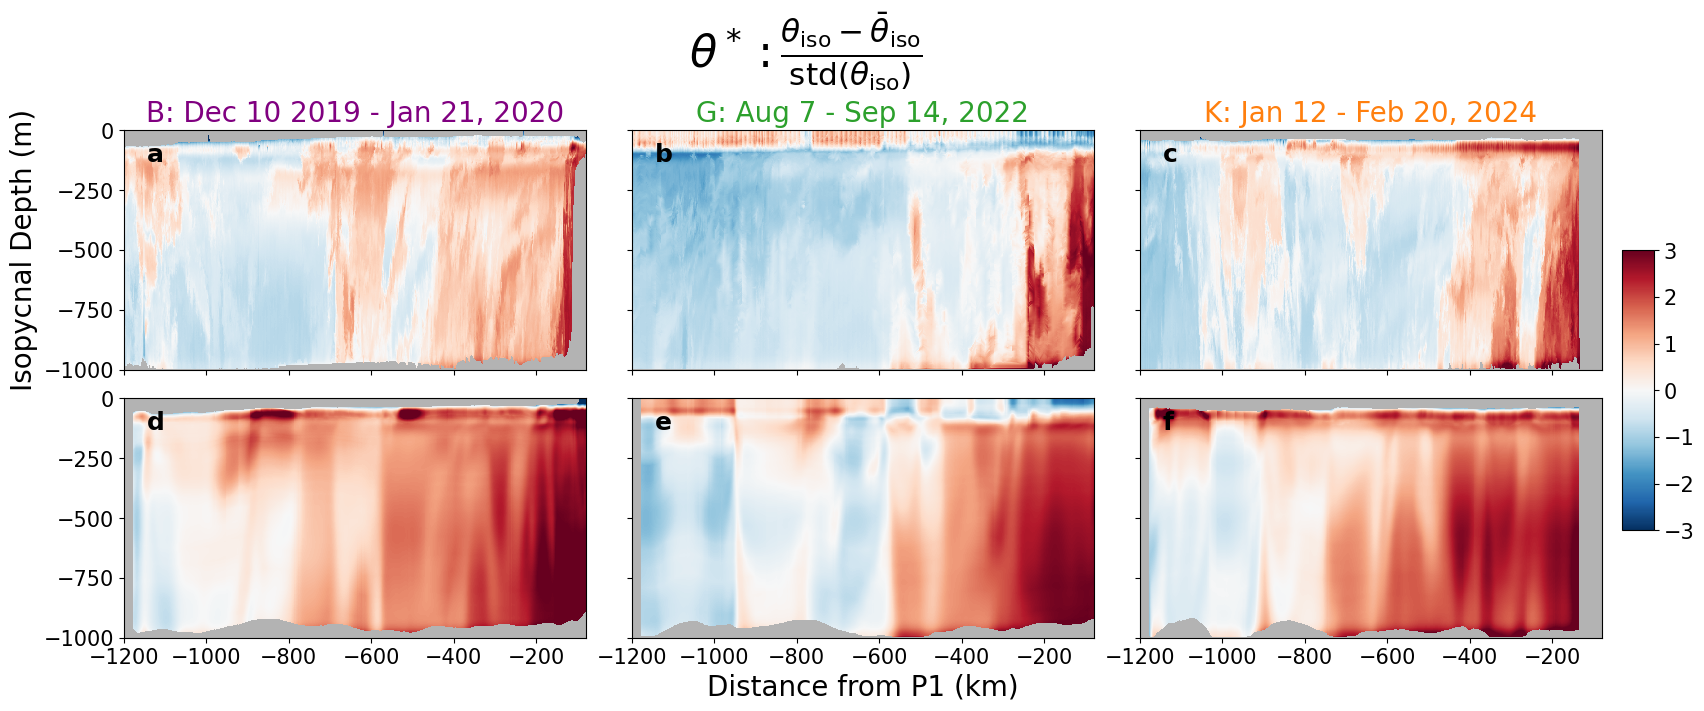

In [9]:
#Open file with 15 glider missions
all_sections_combined =  xr.open_dataset('/Users/Lauryn/THESIS/CPROOF_Work/Files/good_files/all_files15.nc')

#Open file with 15 simulated NEPOM missions
all_synthetic = xr.open_dataset('/Users/Lauryn/THESIS/CPROOF_Work/NEPOM/all_synthetic_files.nc')

###Plot
fig, axs = plt.subplots(2, 3, subplot_kw={'facecolor':'0.7'}, 
                        layout='constrained', sharex=True, sharey=True, figsize=(16,7))

titles =  ['B: Dec 10 2019 - Jan 21, 2020',   'G: Aug 7 - Sep 14, 2022','K: Jan 12 - Feb 20, 2024']
colors = ['purple','tab:green','tab:orange']

vmin=-3
vmax=3
cmap='RdBu_r'
for nn, i in enumerate([1,6,14]):
    glider = all_sections_combined.isel(file=i,depth=slice(0,1000)).sel(distance=slice(-80,-1200))
    model = all_synthetic.isel(file=i)

    im= axs[0,nn].pcolormesh(glider.distance, -glider.depth, ((glider.iso_temps- glider.pot_temp_mean.values)/
                    glider.pot_temp_std.values).T, vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True) 
    axs[0,nn].set_title( titles[nn], fontsize=20, c=colors[nn])

    
    axs[1,nn].pcolormesh(model.distance, -model.depth, ((model.iso_temps.T- glider.pot_temp_mean.values)/
                    glider.pot_temp_std.values).T, vmin=vmin,vmax=vmax,cmap=cmap, rasterized=True) 


        
    
axs[1,1].set_xlabel('Distance from P1 (km)', fontsize=20)
axs[0,0].set_ylabel('Isopycnal Depth (m)',fontsize=20)

fig.suptitle(r'$\theta^*: \frac{\theta_{\text{iso}} - \bar{\theta}_{\text{iso}}}{\text{std}(\theta_{\text{iso}})}$',
                           fontsize=32)
#Label 
cbar_ax = fig.add_axes([1.01, 0.25, 0.02, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)

for i in range(6):
    ax = axs.flat[i]
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

labels = ['a', 'b', 'c','d','e','f','g']

for ax, label in zip(axs.flat, labels):
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
            fontsize=18, fontweight='bold', va='top', ha='left', color='k')

plt.savefig("mod_glider_anom.pdf", format="pdf", bbox_inches="tight")
  

In [43]:
# --- Imports ---
import numpy as np
import xarray as xr
import gsw
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec

# --- Constants / Paths ---
dist_path = '/Users/Lauryn/THESIS/CPROOF_Work/Files/corrected_location/'  # path for uninterpolated data
DEPTH_MIN = 110
DEPTH_MAX = 920
DEPTH_RANGE = range(DEPTH_MIN, DEPTH_MAX)
DIST_SPLIT = -550         # offshore/nearshore boundary
BINS = np.arange(-3, 3.5, 0.03)

# --- Load data ---
# Open file with 15 glider missions
all_sections_combined = xr.open_dataset('/Users/Lauryn/THESIS/CPROOF_Work/Files/good_files/all_files15.nc')
# Open file with 15 simulated NEPOM missions
all_synthetic = xr.open_dataset('/Users/Lauryn/THESIS/CPROOF_Work/NEPOM/all_synthetic_files.nc')


# --- Helpers ---
def open_ds_list(names):
    out = []
    for n in names:
        out.append(xr.open_dataset(f"{dist_path}{n}_corrected_dist.nc"))
    return out


def interpolate_iso_temps(ds, all_sections):
    pot_rho = gsw.pot_rho_t_exact(ds.salinity, ds.potential_temperature, ds.pressure, 0)
    rows = []
    nt = ds.sizes['time']
    for i in range(nt):
        x = np.array(all_sections.iso_density.isel(distance=i))
        xp = np.array(pot_rho.isel(time=i))
        yp = np.array(ds.potential_temperature.isel(time=i))
        rows.append(np.interp(x, xp, yp, left=np.nan, right=np.nan))
    return xr.DataArray(
        rows,
        dims=("time", "depth"),
        coords={"time": ds.time, "depth": ds.depth, "distance": ds.v_distance},
        name="iso_temps"
    )


def flatten_for_hist(anom):
    if "time" in anom.dims:
        flat = anom.stack(_f=("time",)).values
    elif {"file", "distance"} <= set(anom.dims):
        flat = anom.stack(_f=("file", "distance")).values
    elif "distance" in anom.dims:
        flat = anom.stack(_f=("distance",)).values
    else:
        raise ValueError(f"Unexpected dims for histogram: {anom.dims}")
    flat = flat[~np.isnan(flat)]
    return flat


def compute_histograms(group_data, bins, all_sections, depth_min=DEPTH_MIN, depth_max=DEPTH_MAX, bias=0.0):
    """
    Compute depth-resolved histograms of theta*.
    bias is subtracted in theta* space: theta* -> theta* - bias
    """
    depth_count = depth_max - depth_min
    hist_out = np.full((depth_count, len(bins) - 1), np.nan)

    for j_abs in range(depth_min, depth_max):
        j_rel = j_abs - depth_min
        temps = group_data.isel(depth=j_abs)

        mean = all_sections.isel(depth=j_abs).pot_temp_mean.values
        std = all_sections.isel(depth=j_abs).pot_temp_std.values

        # Standardized anomaly (theta*), then subtract bias
        anom = (temps - mean) / std - bias

        flat = flatten_for_hist(anom)
        if flat.size > 0:
            psd, _ = np.histogram(flat, bins=bins, density=True)
            hist_out[j_rel, :] = psd

    hist_out = np.expand_dims(hist_out, axis=0)  # (1, depth_count, bins-1)
    return np.where(hist_out == 0, np.nan, hist_out)


def dist_mission(file, bins=np.arange(-3, 3.5, 0.03), depth_min=110, depth_max=920, bias=0.0):
    """
    Build Section B offshore/nearshore histograms with an optional theta* bias.
    """
    subsets = [
        file,
        file.where(file.distance < DIST_SPLIT, drop=True),
        file.where(file.distance > DIST_SPLIT, drop=True),
    ]
    depth_count = depth_max - depth_min
    all_hist = np.full((3, depth_count, len(bins) - 1), np.nan)

    def get_anom(data, j, use_slice=True):
        """Return standardized anomalies at depth j, with optional slice for reference stats."""
        temps = data.isel(depth=j).iso_temps
        if use_slice:
            ref = all_sections_combined.sel(distance=slice(-80, -1200)).isel(depth=j)
        else:
            ref = all_sections_combined.isel(depth=j)
        mean, std = ref.pot_temp_mean.values, ref.pot_temp_std.values
        anom = (temps - mean) / std - bias   # subtract bias in theta* space
        return anom[~np.isnan(anom)]

    # First pass: determine full weights from the whole file
    full_weights = []
    for j in range(depth_min, depth_max):
        anom = get_anom(file, j, use_slice=True)
        w = np.ones_like(anom) / len(anom) if anom.size > 0 else np.array([])
        full_weights.append(w)

    # Second pass: histograms for each subset
    for i, data in enumerate(subsets):
        for j in range(depth_min, depth_max):
            anom = get_anom(data, j, use_slice=False)
            if anom.size > 0:
                # broadcast the full weight to subset size
                weights = np.ones_like(anom) / max(len(full_weights[j - depth_min]), 1)
                psd, _ = np.histogram(anom, bins=bins, weights=weights)
                all_hist[i, j - depth_min, :] = psd

    return all_hist


# --- Example for Section B (top row line plots) ---
b_hist = dist_mission(all_sections_combined.isel(file=1), bias=0.0)
b_hist_mod = dist_mission(all_synthetic.isel(file=1), bias=0.0)
b_hist_mod_bi = dist_mission(all_synthetic.isel(file=1), bias=1.6)  # NEPOM with theta* - 1.6

# --- Build group lists for glider files ---
bins = BINS
depth_range = DEPTH_RANGE

group_names = {
    "2019":    ["walle2019_jul_WE", "walle2019_dec_EW", "walle2019_dec_WE"],
    "2021-22": ["walle2021_EW", "walle2021_WE", "rosie2022_EW", "rosie2022_WE"],
    "2023-24": ["rosie2023_EW", "rosie2023_WE", "walle2023_EW", "walle2023_WE",
                "rosie2024_EW", "rosie2024_WE", "walle2024_EW", "walle2024_WE"],
}
datasets = {k: open_ds_list(v) for k, v in group_names.items()}

# Interpolate all to iso-density space (DataArray list)
iso_temps = []
for k in group_names:
    for ds in datasets[k]:
        iso_temps.append(interpolate_iso_temps(ds, all_sections_combined))

# Group the iso_temps lists by time period
gps = [iso_temps[0:3], iso_temps[3:7], iso_temps[7:15]]

# Glider histograms (no bias)
all_hist_glider = np.full((3, len(DEPTH_RANGE), len(BINS) - 1), np.nan)
for group_idx in range(3):
    group_data = xr.concat(gps[group_idx], dim="time")
    all_hist_glider[group_idx] = compute_histograms(
        group_data, bins, all_sections_combined,
        depth_min=depth_range.start, depth_max=depth_range.stop, bias=0.0
    )

# NEPOM groups
file_slices = [slice(0, 3), slice(3, 6), slice(7, 14)]

# NEPOM (no bias)
all_hist = np.full((3, len(DEPTH_RANGE), len(BINS) - 1), np.nan)
for group_idx, sl in enumerate(file_slices):
    group_data = xr.concat(all_synthetic.isel(file=sl).iso_temps, dim="distance")
    all_hist[group_idx] = compute_histograms(
        group_data, bins, all_sections_combined,
        depth_min=depth_range.start, depth_max=depth_range.stop, bias=0.0
    )

# NEPOM (theta* - 1.6 bias)
all_hist_bias = np.full((3, len(DEPTH_RANGE), len(BINS) - 1), np.nan)
for group_idx, sl in enumerate(file_slices):
    group_data = xr.concat(all_synthetic.isel(file=sl).iso_temps, dim="distance")
    all_hist_bias[group_idx] = compute_histograms(
        group_data, bins, all_sections_combined,
        depth_min=depth_range.start, depth_max=depth_range.stop, bias=1.6
    )

# Density index ticks
check_values = np.arange(1024.5, 1027.5, 0.5)
depth_ind = [-(np.abs(all_sections_combined.iso_density[:, 0] - val).argmin().values) for val in check_values]

# --- Plot ---
fig = plt.figure(figsize=(22, 18))
gs = gridspec.GridSpec(
    4, 3, height_ratios=[1, 1, 1, 1.3],
    hspace=0.4, wspace=0.25
)

# Top row axes (a, b, c)
axs_top = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2])]

red_map = cm.Reds(np.linspace(0.4, 0.9, 3))
blue_map = cm.Blues(np.linspace(0.4, 0.9, 3))
x = np.linspace(bins[0], bins[-1], b_hist.shape[2])

# --- Top-left: Glider Section B theta* distributions (unchanged) ---
for i, dpth in enumerate([300 - DEPTH_MIN, 900 - DEPTH_MIN]):
    axs_top[0].plot(x, b_hist[1, dpth, :], c=blue_map[i], label=f'Offshore: {dpth + DEPTH_MIN} m')
    axs_top[0].plot(x, b_hist[2, dpth, :], c=red_map[i],  label=f'Nearshore: {dpth + DEPTH_MIN} m')
axs_top[0].set_title(r'Section B $\theta^*$ distributions', fontsize=18)
axs_top[0].legend(loc='upper right', fontsize=13)
axs_top[0].set_xlabel(r'$\theta^*$', fontsize=15)
axs_top[0].set_ylabel(r'Probability Density (0.03 $\theta^*)^{-1}$', fontsize=15)

# --- Top-middle: NEPOM Section B theta* distributions (unchanged) ---
for i, dpth in enumerate([300 - DEPTH_MIN, 900 - DEPTH_MIN]):
    axs_top[1].plot(x, b_hist_mod[1, dpth, :], c=blue_map[i], label=f'Offshore: {dpth + DEPTH_MIN} m')
    axs_top[1].plot(x, b_hist_mod[2, dpth, :], c=red_map[i],  label=f'Nearshore: {dpth + DEPTH_MIN} m')
axs_top[1].set_title(r'NEPOM Section B $\theta^*$ distributions', fontsize=18)
axs_top[1].set_xlabel(r'$\theta^*$', fontsize=15)

# --- Top-right: NEPOM Section B (theta* - 1.6) distributions ---
for i, dpth in enumerate([300 - DEPTH_MIN, 900 - DEPTH_MIN]):
    axs_top[2].plot(x, b_hist_mod_bi[1, dpth, :], c=blue_map[i], label=f'Offshore: {dpth + DEPTH_MIN} m')
    axs_top[2].plot(x, b_hist_mod_bi[2, dpth, :], c=red_map[i],  label=f'Nearshore: {dpth + DEPTH_MIN} m')
axs_top[2].set_title(r'NEPOM Section B $(\theta^* - 1.6)$ distributions', fontsize=18)
axs_top[2].set_xlabel(r'$\theta^*$', fontsize=15)
axs_top[2].legend(loc='upper right', fontsize=13)

for ax, label in zip(axs_top, ['a', 'b', 'c']):
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left', color='k')
    ax.tick_params(labelsize=13)

# --- Lower 3x3 panels (d–i): Glider | NEPOM | NEPOM (theta* - 1.6) ---
axs = np.empty((3, 3), dtype=object)
for i in range(3):
    for j in range(3):
        axs[i, j] = fig.add_subplot(gs[i + 1, j], facecolor='0.7')

group_titles = ['A - C: 2019–2020', 'D - G: 2021–2022', 'H - O: 2023–2024']
group_titles_nepom = ['NEPOM A - C: 2019–2020', 'NEPOM D - G: 2021–2022', 'NEPOM H - O: 2023–2024']
group_titles_bias = ['NEPOM (θ* - 1.6) A - C: 2019–2020',
                     'NEPOM (θ* - 1.6) D - G: 2021–2022',
                     'NEPOM (θ* - 1.6) H - O: 2023–2024']
colors = ['purple', 'tab:green', 'tab:orange']

# extents for imshow
x_extent = [bins[0], bins[-1]]
y_extent = [-DEPTH_MAX, -DEPTH_MIN]

for group_idx in range(3):
    # Column 1: Glider
    im1 = axs[group_idx, 0].imshow(
        all_hist_glider[group_idx],
        extent=[x_extent[0], x_extent[1], y_extent[0], y_extent[1]],
        aspect='auto', origin='upper',
        cmap='Reds', rasterized=True
    )
    axs[group_idx, 0].set_title(group_titles[group_idx], fontsize=20, c=colors[group_idx])
    axs[group_idx, 0].grid(ls='--')
    axs[group_idx, 0].axvline(x=0, c='k')
    axs[group_idx, 0].axvline(x=-2, c='cyan')
    axs[group_idx, 0].axvline(x=3, c='red')
    axs[group_idx, 0].tick_params('x', labelsize=15)
    axs[group_idx, 0].tick_params('y', labelsize=15)

    # Twin y-axis for density ticks
    axs2 = axs[group_idx, 0].twinx()
    axs2.set_yticks(axs[group_idx, 0].get_yticks())
    axs2.set_yticklabels(axs[group_idx, 0].get_yticklabels())
    axs2.tick_params(labelsize=15)
    axs2.set_yticks(np.flip(depth_ind))
    axs2.set_yticklabels(np.flip(['', 25, '', 26, '', 27]))
    if group_idx == 1:
        axs2.set_ylabel('Potential density (kg/m³)', fontsize=16)

    # Column 2: NEPOM (no bias)
    im2 = axs[group_idx, 1].imshow(
        all_hist[group_idx],
        extent=[x_extent[0], x_extent[1], y_extent[0], y_extent[1]],
        aspect='auto', origin='upper',
        cmap='Reds', rasterized=True, vmin=0, vmax=1.6
    )
    axs[group_idx, 1].set_title(group_titles_nepom[group_idx], fontsize=20, c=colors[group_idx])
    axs[group_idx, 1].grid(ls='--')
    axs[group_idx, 1].axvline(x=0, c='k')
    axs[group_idx, 1].axvline(x=-2, c='cyan')
    axs[group_idx, 1].axvline(x=3, c='red')
    axs[group_idx, 1].tick_params('x', labelsize=15)
    axs[group_idx, 1].tick_params('y', labelsize=15)

    # Column 3: NEPOM (theta* - 1.6)
    im3 = axs[group_idx, 2].imshow(
        all_hist_bias[group_idx],
        extent=[x_extent[0], x_extent[1], y_extent[0], y_extent[1]],
        aspect='auto', origin='upper',
        cmap='Reds', rasterized=True, vmin=0, vmax=1.6
    )
    axs[group_idx, 2].set_title(group_titles_bias[group_idx], fontsize=20, c=colors[group_idx])
    axs[group_idx, 2].grid(ls='--')
    axs[group_idx, 2].axvline(x=0, c='k')
    axs[group_idx, 2].axvline(x=-2, c='cyan')
    axs[group_idx, 2].axvline(x=3, c='red')
    axs[group_idx, 2].tick_params('x', labelsize=15)
    axs[group_idx, 2].tick_params('y', labelsize=15)

# Bottom labels & y-label
axs[2, 0].set_xlabel(r'$\theta^{*}$', fontsize=18)
axs[2, 1].set_xlabel(r'$\theta^{*}$', fontsize=18)
axs[2, 2].set_xlabel(r'$\theta^{*}$', fontsize=18)
axs[1, 0].set_ylabel('Isopycnal depth (m)', fontsize=18)

# Colorbar next to column 3
pos = axs[1, 2].get_position()
cbar_ax2 = fig.add_axes([pos.x1 + 0.03, pos.y0, 0.009, pos.height])
cbar2 = fig.colorbar(im3, cax=cbar_ax2)
cbar2.ax.tick_params(labelsize=15)
cbar2.ax.set_ylabel(r'Probability Density (0.03 $\theta^{*}$)$^{-1}$', fontsize=18)

# Panel labels (d–i for the lower block)
labels_lower = ['d', 'e', 'f', 'g', 'h', 'i']
for ax, label in zip(axs.flat, labels_lower):
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left', color='black')

plt.savefig("combined_theta_star_panels.pdf", format="pdf", bbox_inches="tight")
plt.close(fig)


## Figure 10

In [2]:
####### Observations 

#Load Line P climatology to use consistent P1 coordinates for distance
climate_file = '/Users/Lauryn/THESIS/CPROOF_Work/Climatology/LineP_climatology_1956to2012.nc'
with xr.open_dataset(climate_file) as clim:
    clim['distance'] = [
        geopy.distance.geodesic(
            (48.56127328, -125.53143223),
            (clim.latitude[i], clim.longitude[i])
        ).km for i in range(len(clim.longitude))
    ]

#Open Line P CTD data
ds = xr.open_dataset('/Users/Lauryn/THESIS/Tully_ctd/LinePGrid.nc')
all_sections_combined = xr.open_dataset('/Users/Lauryn/THESIS/CPROOF_Work/Files/good_files/all_files15.nc')

# Compute SA, pot_temp, pot_density
SA = gsw.SA_from_SP(ds.salinity, ds.pressure, ds.longitude, ds.latitude)
ds['pot_temp'] = gsw.pt_from_t(SA, ds.temperature, ds.pressure, 0)
ds['pot_density'] = gsw.pot_rho_t_exact(SA, ds.pot_temp, ds.pressure, 0)

# Interp ship onto glider depths
ds_interp = ds.interp(depth=all_sections_combined.depth)
ds_interp['anom'] = (ds_interp.pot_temp - all_sections_combined.pot_temp_mean) / all_sections_combined.pot_temp_std

# Subset ship data
subset = ds_interp.isel(mission_ind=slice(192, 204))
subset['distance'] = -np.array([
    geopy.distance.geodesic(
        (48.56127328, -125.53143223),
        (clim.latitude[i], clim.longitude[i])
    ).km for i in range(len(clim.longitude))
])
subset = subset.assign_coords(distance=("station_ind", subset['distance'].values))
subset = subset.swap_dims({"station_ind": "distance"})

# Interpolate ship onto glider distances
all_sections_combined['time_dt'] = (all_sections_combined.time * 1e9).astype('datetime64[ns]')
ship_glider_track = subset.interp(distance=all_sections_combined.distance)

subset_anom = xr.Dataset(
    {
        "anom": (
            ("mission", "distance"),
            ship_glider_track.anom.isel(depth=slice(110, 920)).mean('depth').values
        ),
        "time": ("mission", ship_glider_track.mission_time.values)
    },
    coords={
        "distance": -ship_glider_track.distance.values,
        "mission": ship_glider_track.mission_ind.values,
    }
)

# Glider anomalies
all_sections_combined['anom'] = (
    (all_sections_combined.iso_temps - all_sections_combined.pot_temp_mean)
    / all_sections_combined.pot_temp_std
)
gliders_shipx = xr.Dataset(
    {
        "anom": (
            ("mission", "distance"),
            all_sections_combined['anom'].isel(depth=slice(110, 920)).mean('depth').values
        ),
        "time": ("mission", all_sections_combined.time_dt.isel(distance=1200, depth=2).values)
    },
    coords={
        "distance": -all_sections_combined.distance.values,
        "mission": all_sections_combined.file.values,
    }
)

# Combine ship + glider
glider_ship_concat = xr.concat([subset_anom, gliders_shipx], dim=('mission'))
glider_ship_concat['distance'] = -glider_ship_concat['distance']
glider_ship_concat_sorted = glider_ship_concat.sortby("time")

# Extension line finder (obs)
def extension_adjusted(data):
    anom1=data[~np.isnan(data)]
    idx=0
    for i in range(len(data)-1):
        
        if data[i + 1] < 0 and data[i] >= 0 :
            idx=glider_ship_concat_sorted.distance[i]
            break

    return idx

dist2=[]
for i in range(len(glider_ship_concat_sorted.mission)):
    dist2.append((int(extension_adjusted(glider_ship_concat_sorted.isel(mission=i).anom))))
dist2[6]=np.nan

######### NPEOM daily averaged data from 2019 - 
section = all_sections_combined.isel(file=1).sel(distance=slice(-80, -1200), depth=slice(0, 1000))
model_path = '/Users/Lauryn/THESIS/CPROOF_Work/NEPOM/'

def load_model_anom(year):
    mod = xr.open_dataset(f"{model_path}LineP_{year}_2.nc")
    mod = mod.sortby("distance").sel(distance=slice(-1200, -80), depth=slice(0, 1000))
    anoms = np.empty(np.shape(mod.votemper))
    anoms[:] = np.nan
    for i in range(len(mod.time)):
        anoms[i, :, :] = (((mod.votemper[i].T) - section.pot_temp_mean.values) / section.pot_temp_std.values).T
    mod['anoms'] = (('time', 'depth', 'distance'), anoms)
    anom_mean = mod['anoms'].sel(depth=slice(110, 920)).mean('depth')
    anom_mean['time'] = anom_mean['time'].time_centered.values
    return anom_mean 

anom19_mean = load_model_anom(2019).isel(time=slice(100, 365))#####trim 2019 to start in sept when glider dataset starts 
anom20_mean = load_model_anom(2020)
anom21_mean = load_model_anom(2021)
anom22_mean = load_model_anom(2022)
anom23_mean = load_model_anom(2023)
anom24_mean = load_model_anom(2024)

anoms_concat = xr.concat([anom19_mean, anom20_mean, anom21_mean, anom22_mean, anom23_mean, anom24_mean], dim='time')



# Extension line finder (model)
def extension_adjusted2(data):
    idx=0
    for i in range(len(data)-1):
        if data[i + 1] > 1.6 and data[i] <= 1.6: #the signs are different because I want to start counting by -80
                                                #rather than -1200 km 
            idx = i
    return idx

extension = []
for i in range(len(anoms_concat.time)):
    extension.append(extension_adjusted2(anoms_concat[i]))


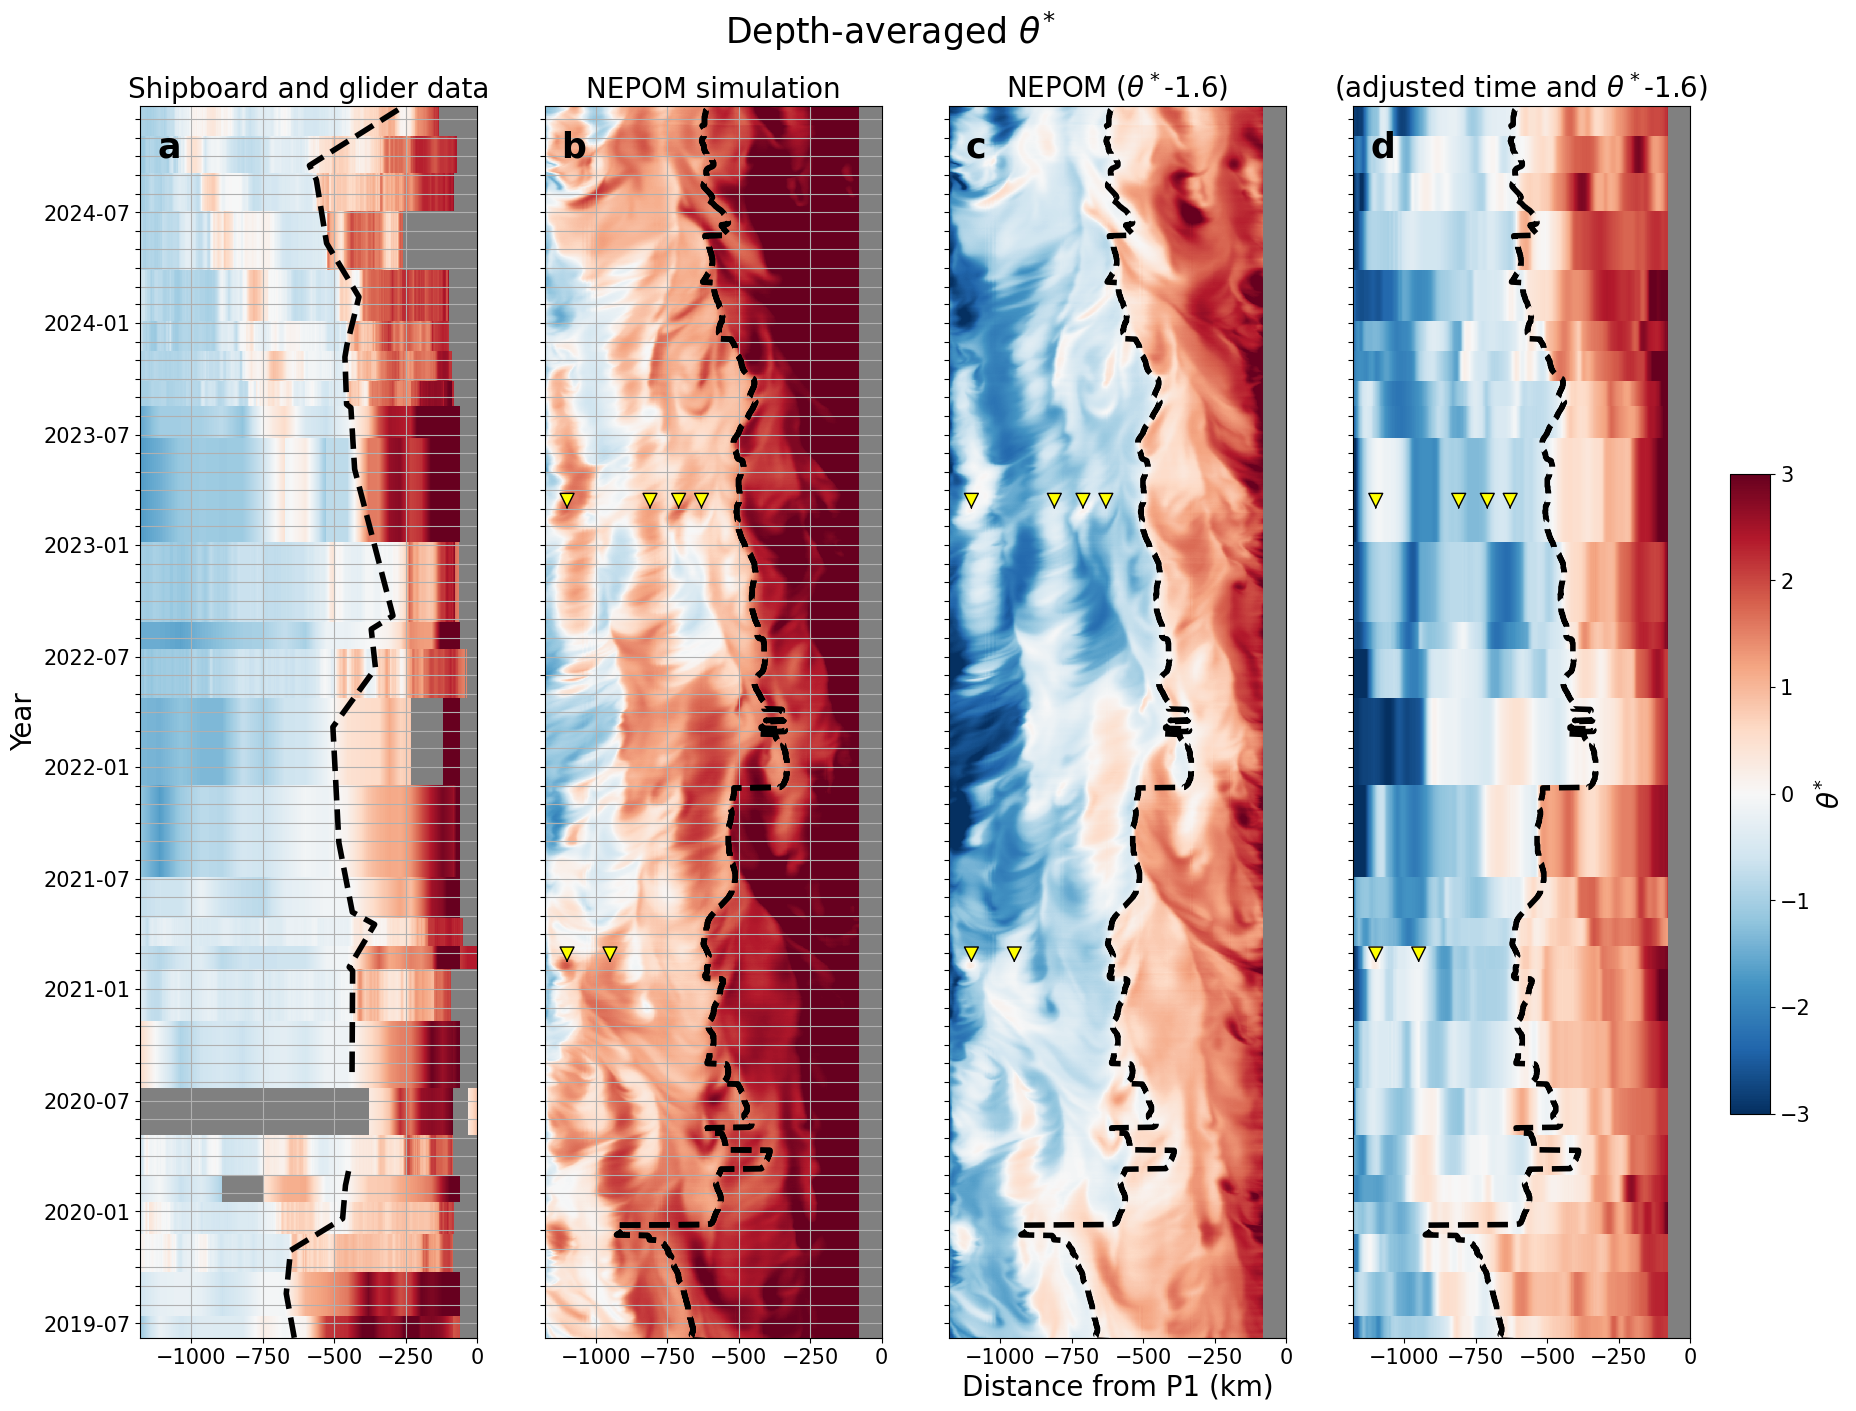

In [3]:
################## Plot ####################
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20, 16))

vmin, vmax, cmap = -3, 3, 'RdBu_r'

#Glider + ship
axs[0].set_facecolor('gray')
pcm0 = axs[0].pcolormesh(
    glider_ship_concat_sorted.distance, glider_ship_concat_sorted.time,
    glider_ship_concat_sorted.anom, cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True
)
axs[0].plot(dist2,glider_ship_concat_sorted.time,c='k' ,ls='--' ,linewidth=4)
axs[0].set_ylabel('Year', fontsize=20)
axs[0].set_title('Shipboard and glider data', fontsize=20)
axs[0].tick_params(axis='y', labelsize=15)
axs[0].tick_params(axis='x', labelsize=15)

# Format y-axis as months
axs[0].yaxis.set_major_locator(mdates.MonthLocator())
axs[0].yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
for i, label in enumerate(axs[0].get_yticklabels()):
    if i % 6 != 0:
        label.set_visible(False)

#####NEPOM
axs[1].set_facecolor('gray')
pcm1 = axs[1].pcolormesh(
    anoms_concat.distance, anoms_concat.time, anoms_concat,
    vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True
)
axs[1].plot(anoms_concat.distance[extension], anoms_concat.time, 'k--', linewidth=4)
axs[1].set_title('NEPOM simulation', fontsize=20)


axs[0].set_xlim(-1178, None)
axs[0].set_ylim(glider_ship_concat_sorted.time[0], glider_ship_concat_sorted.time[-1])


############### new plots 
axs[2].set_facecolor('gray')
pcm1 = axs[2].pcolormesh(
    anoms_concat.distance, anoms_concat.time, anoms_concat-1.6,
    vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True
)


for i in range(1,4):
    axs[i].plot(anoms_concat.distance[extension], anoms_concat.time, 'k--', linewidth=4)

    axs[i].annotate('', xy=(-1100, pd.to_datetime('2021-02-13T12:00:00')), xytext=(-1100, pd.to_datetime('2021-02-16T12:00:00')),
                 arrowprops=dict(facecolor='yellow', arrowstyle='-|>', shrinkA=0, shrinkB=5,mutation_scale=25, linewidth=1))
    axs[i].annotate('', xy=(-950, pd.to_datetime('2021-02-13T12:00:00')), xytext=(-950, pd.to_datetime('2021-02-16T12:00:00')),
                 arrowprops=dict(facecolor='yellow', arrowstyle='-|>', shrinkA=0, shrinkB=5,mutation_scale=25, linewidth=1))

    axs[i].annotate('', xy=(-1100,pd.to_datetime('2023-03-01T12:00:00')), xytext=(-1100, pd.to_datetime('2023-03-03T12:00:00')),
                 arrowprops=dict(facecolor='yellow', arrowstyle='-|>', shrinkA=0, shrinkB=5,mutation_scale=25, linewidth=1))
    axs[i].annotate('', xy=(-810, pd.to_datetime('2023-03-01T12:00:00')), xytext=(-810, pd.to_datetime('2023-03-03T12:00:00')),
                 arrowprops=dict(facecolor='yellow', arrowstyle='-|>', shrinkA=0, shrinkB=5,mutation_scale=25, linewidth=1))
    axs[i].annotate('', xy=(-710, pd.to_datetime('2023-03-01T12:00:00')), xytext=(-710, pd.to_datetime('2023-03-03T12:00:00')),
                 arrowprops=dict(facecolor='yellow', arrowstyle='-|>', shrinkA=0, shrinkB=5,mutation_scale=25, linewidth=1))
    axs[i].annotate('', xy=(-630, pd.to_datetime('2023-03-01T12:00:00')), xytext=(-630, pd.to_datetime('2023-03-03T12:00:00')),
                 arrowprops=dict(facecolor='yellow', arrowstyle='-|>', shrinkA=0, shrinkB=5,mutation_scale=25, linewidth=1))
    axs[i].tick_params(axis='y', labelsize=15)
    axs[i].tick_params(axis='x', labelsize=15)
    
axs[2].set_title(r'NEPOM ($\theta^*$-1.6)', fontsize=20)

#
mod_coarse=(anoms_concat-1.6).interp(time=glider_ship_concat_sorted.time)
axs[3].set_facecolor('gray')
pcm1 = axs[3].pcolormesh(
    anoms_concat.distance, glider_ship_concat_sorted.time, mod_coarse,
    vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True
)
axs[3].set_title(r'(adjusted time and $\theta^*$-1.6) ', fontsize=20)


axs[2].set_xlabel('Distance from P1 (km)', fontsize=20)


for ax, label in zip(axs, ['a', 'b','c','d','e']):
    ax.text(0.05, 0.98, label, transform=ax.transAxes,
            fontsize=25, fontweight='bold', va='top', ha='left', color='k')
axs[0].grid(); axs[1].grid()

#####
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.4])
cbar = fig.colorbar(pcm1, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_ylabel(r'$\theta^{*}$', fontsize=20)


fig.suptitle(r'Depth-averaged $\theta^{*}$', fontsize=25, y=0.94)
plt.savefig("hovmoller.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Figure 11

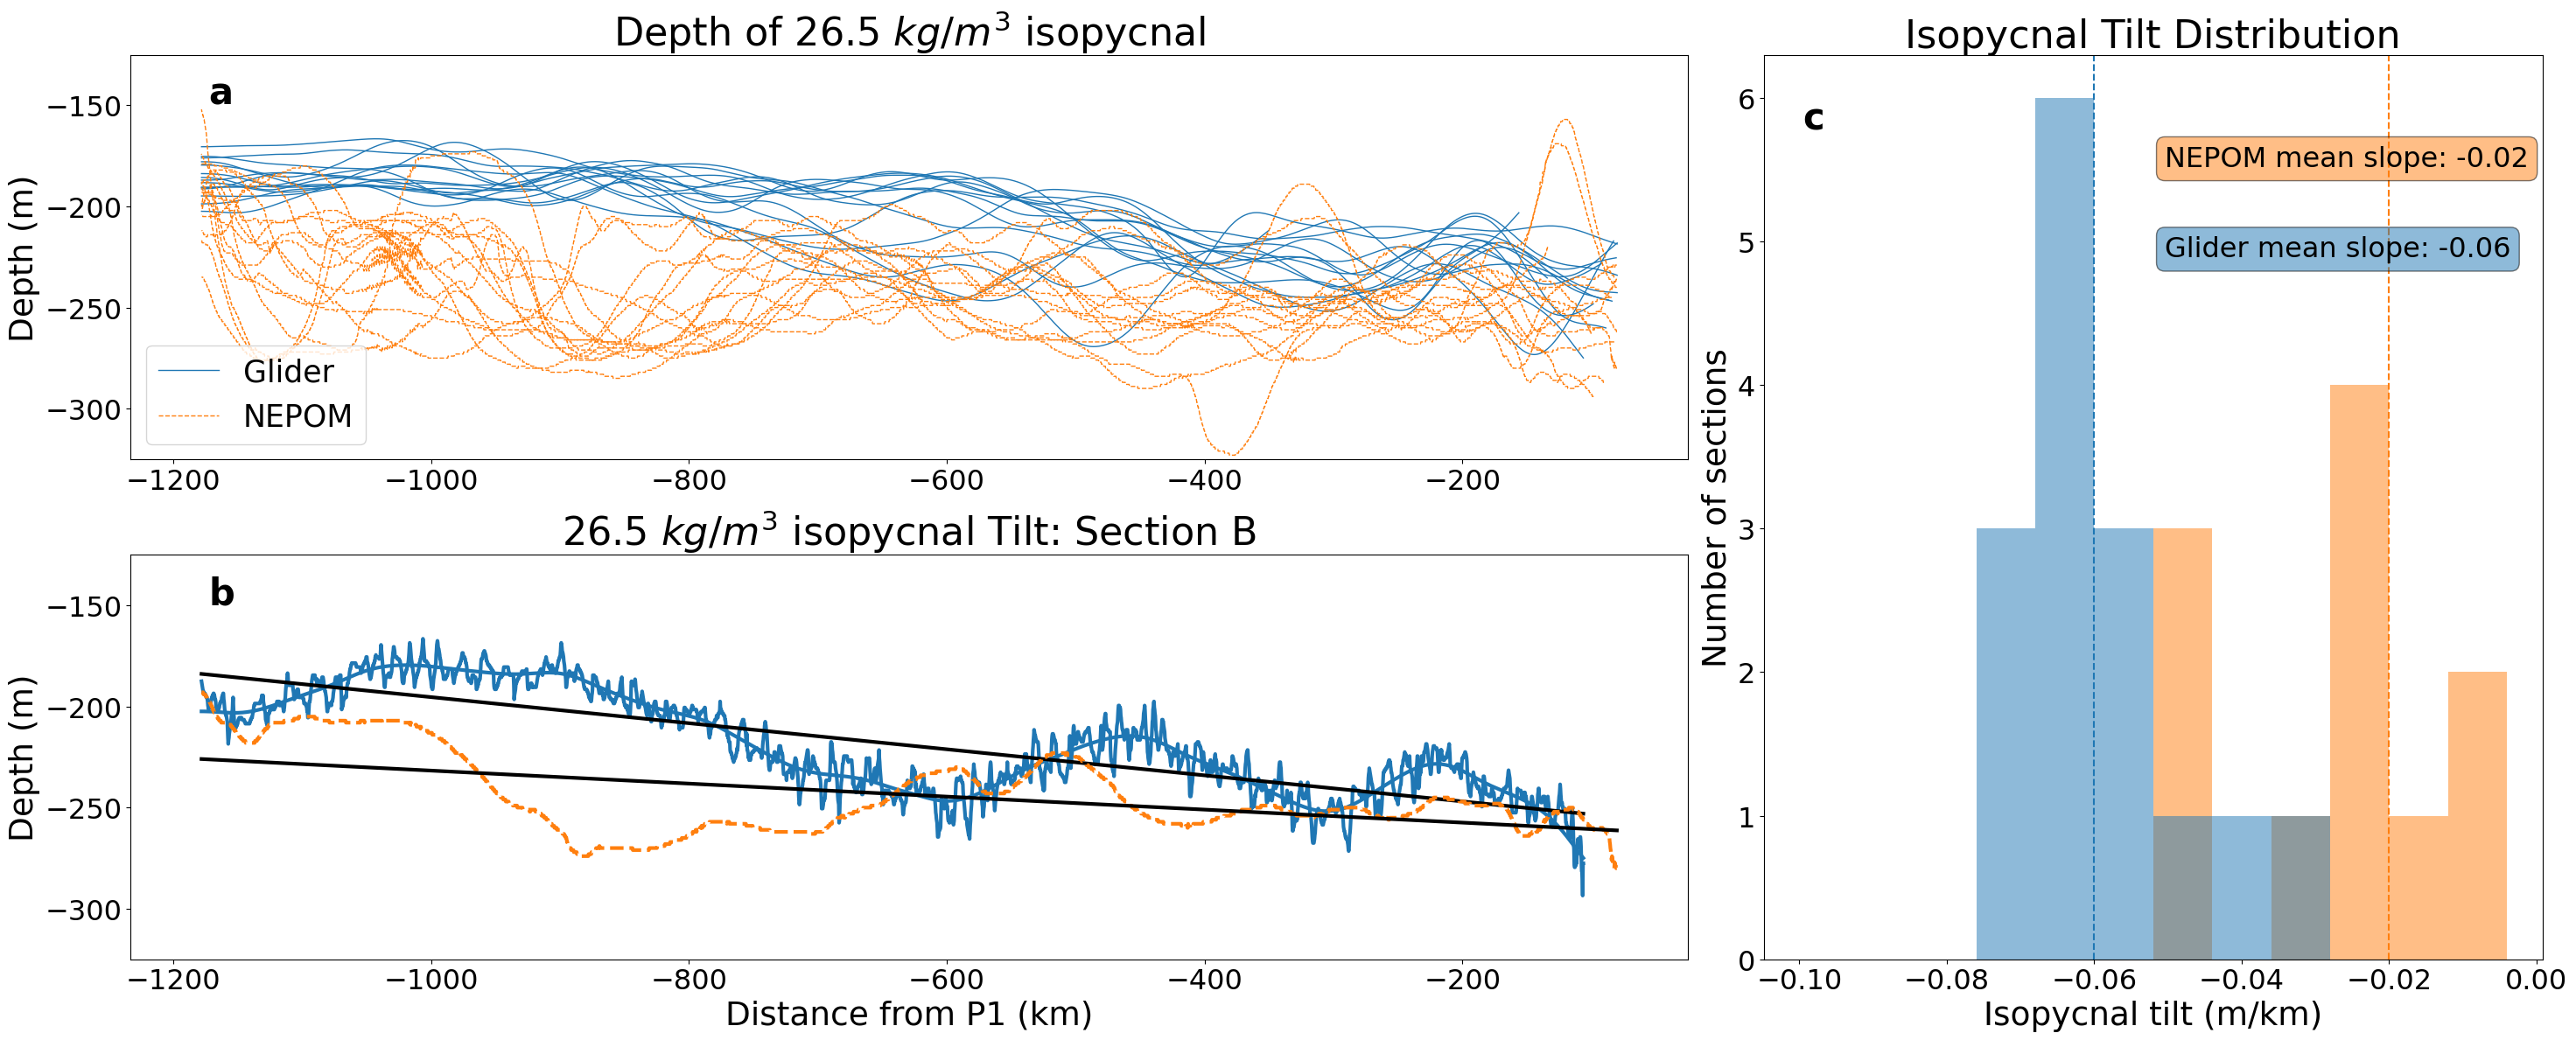

In [30]:
def density_depth (data):
    target_density = 1026.5
    valid = ~np.isnan(data)

    # Find the index of the closest pot_density along the depth axis for each distance
    data = data.where(valid, drop=True)    

    diff =data- target_density
    closest_idx = abs(diff).argmin(dim="depth")
    big_jump = closest_idx.where((closest_idx.diff('distance') >20)| (closest_idx.diff('distance') < -20), drop=True)
    
    if len(big_jump) > 0: 
        good_idx= closest_idx.where(diff.distance < big_jump[-1].distance,drop=True ).astype('int')
    else: 
        good_idx = closest_idx
    depth_at_target_density = -diff.depth.isel(depth=good_idx)

    return depth_at_target_density

def butter_lowpass(cuttoff,order=2):
    nyquist = 1/0.25
    normal_cutoff = cutoff/nyquist
    b,a = signal.butter(order,normal_cutoff,btype='low',analog=False)
    return b,a

def butter_lowpass_filter(data,cutoff,order=2):
    b,a = butter_lowpass(cutoff, order=order)
    y=signal.filtfilt(b,a,data)
    return y

cutoff=1/50
 
### Find slope of isopycnal 
glider_slopes=[]
for i in range(15):
    t = all_sections_combined.isel(file=i).sel(distance=slice(-80,-1100)).pot_density
    depth_at_target_density=density_depth(t)
    m, b = np.polyfit(depth_at_target_density.distance, depth_at_target_density, deg=1)
    glider_slopes.append(m)
    
model_slopes=[]
for i in range(15):
    t = all_synthetic.isel(file=i).sel(distance=slice(-80,-1100)).pot_density
    depth_at_target_density=density_depth(t)
    m, b = np.polyfit(depth_at_target_density.distance, depth_at_target_density, deg=1)
    model_slopes.append(m)

###Plot 

fig = plt.figure(figsize=(30,12))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0], sharex=ax0, sharey=ax0)
ax2 = fig.add_subplot(gs[:, 1])  # This spans both rows
 
###Plot all slopes 
for i in range(15):
    label = 'Glider' if i == 0 else None
    t = all_sections_combined.isel(file=i).sel(distance=slice(-80, -1178)).pot_density
    depth = density_depth(t)
    smoothed_data = butter_lowpass_filter(depth, cutoff=0.02,order=2)##smooth away internal waves
    ax0.plot(depth.distance, smoothed_data, label=label, c='tab:blue', linewidth=1)


for i in range(15):
    label = 'NEPOM' if i == 0 else None
    t = all_synthetic.isel(file=i).sel(distance=slice(-80, -1178)).pot_density.T
    depth = density_depth(t)
    ax0.plot(depth.distance, depth, label=label, ls='--', c='tab:orange', linewidth=1)

ax0.set_ylim(-325, -125)
ax0.set_title(r'Depth of 26.5 $kg/m^{3}$ isopycnal', fontsize=32)
ax0.legend(fontsize=25,loc='lower left')
ax0.tick_params(axis='y', labelsize=23)
ax0.tick_params(axis='x', labelsize=23)
ax0.set_ylabel('Depth (m)', fontsize=27)

###Compare mission B 
for i in range(1, 2):   
    # Glider
    t = all_sections_combined.isel(file=i).sel(distance=slice(-80, -1178)).pot_density
    depth = density_depth(t)
    smoothed_data = butter_lowpass_filter(depth, cutoff=0.02,order=2)
    m, b = np.polyfit(depth.distance, depth, deg=1)
    ax1.plot(depth.distance, depth, label='Glider', c='tab:blue', linewidth=3)
    ax1.plot(depth.distance, smoothed_data, label='Glider', c='tab:blue', linewidth=3)
    ax1.plot(depth.distance, depth.distance * m + b, c='k',linewidth=3)

    # Synthetic
    t = all_synthetic.isel(file=i).sel(distance=slice(-80, -1178)).pot_density
    depth = density_depth(t)
    m, b = np.polyfit(depth.distance, depth, deg=1)
    ax1.plot(depth.distance, depth, label='NEPOM', c='tab:orange', linewidth=3, ls='--')
    ax1.plot(depth.distance, depth.distance * m + b, linewidth=3,c='k')

ax1.set_title(r'26.5 $kg/m^{3}$ isopycnal Tilt: Section B', fontsize=32)
ax1.set_xlabel('Distance from P1 (km)', fontsize=27)
ax1.set_ylabel('Depth (m)', fontsize=27)
ax1.tick_params(axis='y', labelsize=23)
ax1.tick_params(axis='x', labelsize=23)

### Histogram  
bins = np.arange(-10e-2, 0, 0.008)

ax2.hist(model_slopes, bins=bins, alpha=0.5, label='NEPOM', color='tab:orange')
ax2.axvline(x=np.round(np.mean(model_slopes), 2), ls='--',c='tab:orange')
ax2.hist(glider_slopes, bins=bins, alpha=0.5, label='Glider', color='tab:blue')
ax2.axvline(x=np.round(np.mean(glider_slopes), 2), ls='--',c='tab:blue')

# Text boxes
txt = f'Glider mean slope: {np.round(np.mean(glider_slopes), 2)}'
props = dict(boxstyle='round', facecolor='tab:blue', alpha=0.5)
ax2.text(0.515, 0.8, txt, transform=ax2.transAxes, fontsize=23,
         bbox=props, verticalalignment='top', c='k')

txt = f'NEPOM mean slope: {np.round(np.mean(model_slopes), 2)}'
props = dict(boxstyle='round', facecolor='tab:orange', alpha=0.5)
ax2.text(0.515, 0.9, txt, transform=ax2.transAxes, fontsize=23,
         bbox=props, verticalalignment='top', c='k')

ax2.set_xlabel('Isopycnal tilt (m/km)', fontsize=27)
ax2.set_ylabel('Number of sections', fontsize=27)
ax2.set_title('Isopycnal Tilt Distribution', fontsize=32)
ax2.tick_params(axis='y', labelsize=23)
ax2.tick_params(axis='x', labelsize=23)

axes = [ax0, ax1, ax2]
labels = ['a', 'b', 'c']

for ax, label in zip(axes, labels):
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
            fontsize=30, fontweight='bold', va='top', ha='left', color='k')

plt.tight_layout()
plt.savefig("iso_disp.pdf", format="pdf", bbox_inches="tight")
